# 1 Importing Libraries/Functions and File Input

In [25]:
# Import all necessary libraries
import os
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import shap
import plotly.express as px
import torch as t
import torch.nn as nn
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import random
import missingno as msno
import itertools
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from imblearn.pipeline import Pipeline
from sklearn import set_config
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

In [26]:
# Define all necessary functions
def get_scores(Y, Y_pred):
    """
    Computes various evaluation metrics for model predictions.

    Parameters:
    - Y: Actual target values.
    - Y_pred: Predicted target values by the model.

    Returns:
    - conf_matrix: Confusion matrix showing true positives, true negatives, false positives, and false negatives.
    - class_report: Classification report detailing precision, recall, and F1-score for each class.
    - auc: Area Under the Curve (AUC) value for the model's predictions.
    - acc: Accuracy of the model's predictions.
    """
    conf_matrix = confusion_matrix(Y, Y_pred)
    class_report = classification_report(Y, Y_pred)
    auc = roc_auc_score(Y, Y_pred)
    acc = accuracy_score(Y, Y_pred)

    return conf_matrix, class_report, auc, acc

def print_scores(conf_matrix, class_report, auc, acc):
    """
    Prints the evaluation metrics in a structured format.

    Parameters:
    - conf_matrix: Confusion matrix from get_scores function.
    - class_report: Classification report from get_scores function.
    - auc: AUC value from get_scores function.
    - acc: Accuracy value from get_scores function.
    """
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

In [27]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_directory)

Current Working Directory: /Users/andyt/Library/CloudStorage/OneDrive-UniversityofToronto/Research/IEEE EMBS 2024


In [ ]:
df = pd.read_excel('Diabetes Study File 10K Dec 14 2017.xlsx')
df

# 2 Data Preprocessing

## 2.1 Data Cleaning

### 2.1.1 Remove multiple patient visits and retain the most recent record

In [29]:
duplicates = df['Patient_ID'].duplicated().sum()
duplicates

1398

In [30]:
pd.set_option('display.float_format', '{:.0f}'.format)

In [ ]:
duplicated_patient_ids = df[df['Patient_ID'].duplicated()]['Patient_ID'].unique()

In [33]:
df.sort_values(by=['Patient_ID', 'Age_at_Exam'], ascending=[True, False], inplace=True)

# Keep only the first occurrence of each 'Patient_ID', which corresponds to the oldest age
df.drop_duplicates(subset='Patient_ID', keep='first', inplace=True)

In [35]:
df.shape

(8602, 43)

In [36]:
# Reset the display.float_format option to its default setting
pd.reset_option('display.float_format')

# 3 Exploratory Data Analysis and Feature Engineering

In [37]:
df.dtypes

Age_at_Exam                                         int64
sBP                                               float64
sBP_Date                                   datetime64[ns]
BMI                                               float64
BMI_Date                                   datetime64[ns]
LDL                                               float64
LDL_Date                                   datetime64[ns]
HDL                                               float64
HDL_Date                                   datetime64[ns]
A1c                                               float64
A1c_Date                                   datetime64[ns]
TG                                                float64
TG_Date                                    datetime64[ns]
FBS                                               float64
FBS_Date                                   datetime64[ns]
FBS>DM                                              int64
Total_Cholesterol                                 float64
Total_Choleste

In [38]:
df.isnull().sum()

Age_at_Exam                                   0
sBP                                           4
sBP_Date                                      0
BMI                                           0
BMI_Date                                      0
LDL                                          52
LDL_Date                                      0
HDL                                          68
HDL_Date                                     61
A1c                                           0
A1c_Date                                      0
TG                                           51
TG_Date                                      41
FBS                                           0
FBS_Date                                      0
FBS>DM                                        0
Total_Cholesterol                           200
Total_Cholesterol_Lab_Date                  191
Diabetes                                      0
DM_OnsetDate                               4462
Depression                              

In [39]:
# Calculate the percentage of missing
missing_perc = df.isnull().mean()*100

# Getting name of column with more X% missing
def get_columns_with_missing(data, threshold):
    columns_with_missing = []

    for column, perc in data.items():
        if perc >= threshold:
            columns_with_missing.append(column)

    return columns_with_missing

columns_missing_75 = get_columns_with_missing(missing_perc, 75)
columns_missing_50 = get_columns_with_missing(missing_perc, 50)
columns_missing_10 = get_columns_with_missing(missing_perc, 10)
columns_missing_5 = get_columns_with_missing(missing_perc, 5)

print(f'Columns with missing values > {75}%: {columns_missing_75}')
print(f'Columns with missing values > {50}%: {columns_missing_50}')
print(f'Columns with missing values > {10}%: {columns_missing_10}')
print(f'Columns with missing values > {5}%: {columns_missing_5}')

Columns with missing values > 75%: ['Depression_OnsetDate', 'COPD_Date']
Columns with missing values > 50%: ['DM_OnsetDate', 'Depression_OnsetDate', 'OA_OnsetDate', 'COPD_Date', 'Corticosteroids', 'Corticosteroids_first_instance', 'leastO(DM_OnsetDate)', 'LeastOfAll', 'A1C_BEF_DM', 'FBS_BEF_DM', 'DM_Onset_Revised', 'DM_Onset_Revised_1YrPrior']
Columns with missing values > 10%: ['DM_OnsetDate', 'Depression_OnsetDate', 'HTN_OnsetDate', 'OA_OnsetDate', 'COPD_Date', 'Hypertension_Medications', 'Hypertension_Medications_First_Instance', 'Corticosteroids', 'Corticosteroids_first_instance', 'leastO(A1c_Date)', 'leastO(DM_OnsetDate)', 'leastO(FBS_Date)', 'LeastOfAll', 'A1C_BEF_DM', 'FBS_BEF_DM', 'DM_Onset_Revised', 'DM_Onset_Revised_1YrPrior']
Columns with missing values > 5%: ['DM_OnsetDate', 'Depression_OnsetDate', 'HTN_OnsetDate', 'OA_OnsetDate', 'COPD_Date', 'Hypertension_Medications', 'Hypertension_Medications_First_Instance', 'Corticosteroids', 'Corticosteroids_first_instance', 'leastO(

In [40]:
# Compute the count of each class in the 'target' column
counts = df['Diabetes'].value_counts()

# Define colors for the pie chart sections
colors = ['#a3416c', '#ebc898']

# Construct a pie chart with plotly
# 'names' are the class labels, and 'values' are the counts for each class
fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # creates a donut-styled pie chart
    title='Distribution of Classes in "target"',
    color_discrete_sequence=colors
)

# Update the layout of the pie chart for better presentation and clarity
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='DIABETES'
    ),
    title=dict(
        text='Distribution of Classes in "DIABETES"',
        x=0.45,
        xanchor='center',
        y=0.95,
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

# Display the pie chart
fig.show()

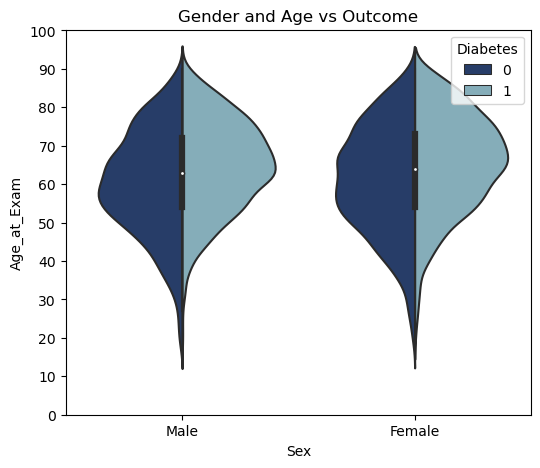

In [41]:
# Display violin plot
plt.figure(figsize=(6, 5))
sns.violinplot(x="Sex", y="Age_at_Exam", hue="Diabetes",
               data=df, split=True, palette=['#1c3a73', '#7cb1c2'])
plt.title('Gender and Age vs Outcome')
plt.yticks(range(0, 110, 10))
plt.show()

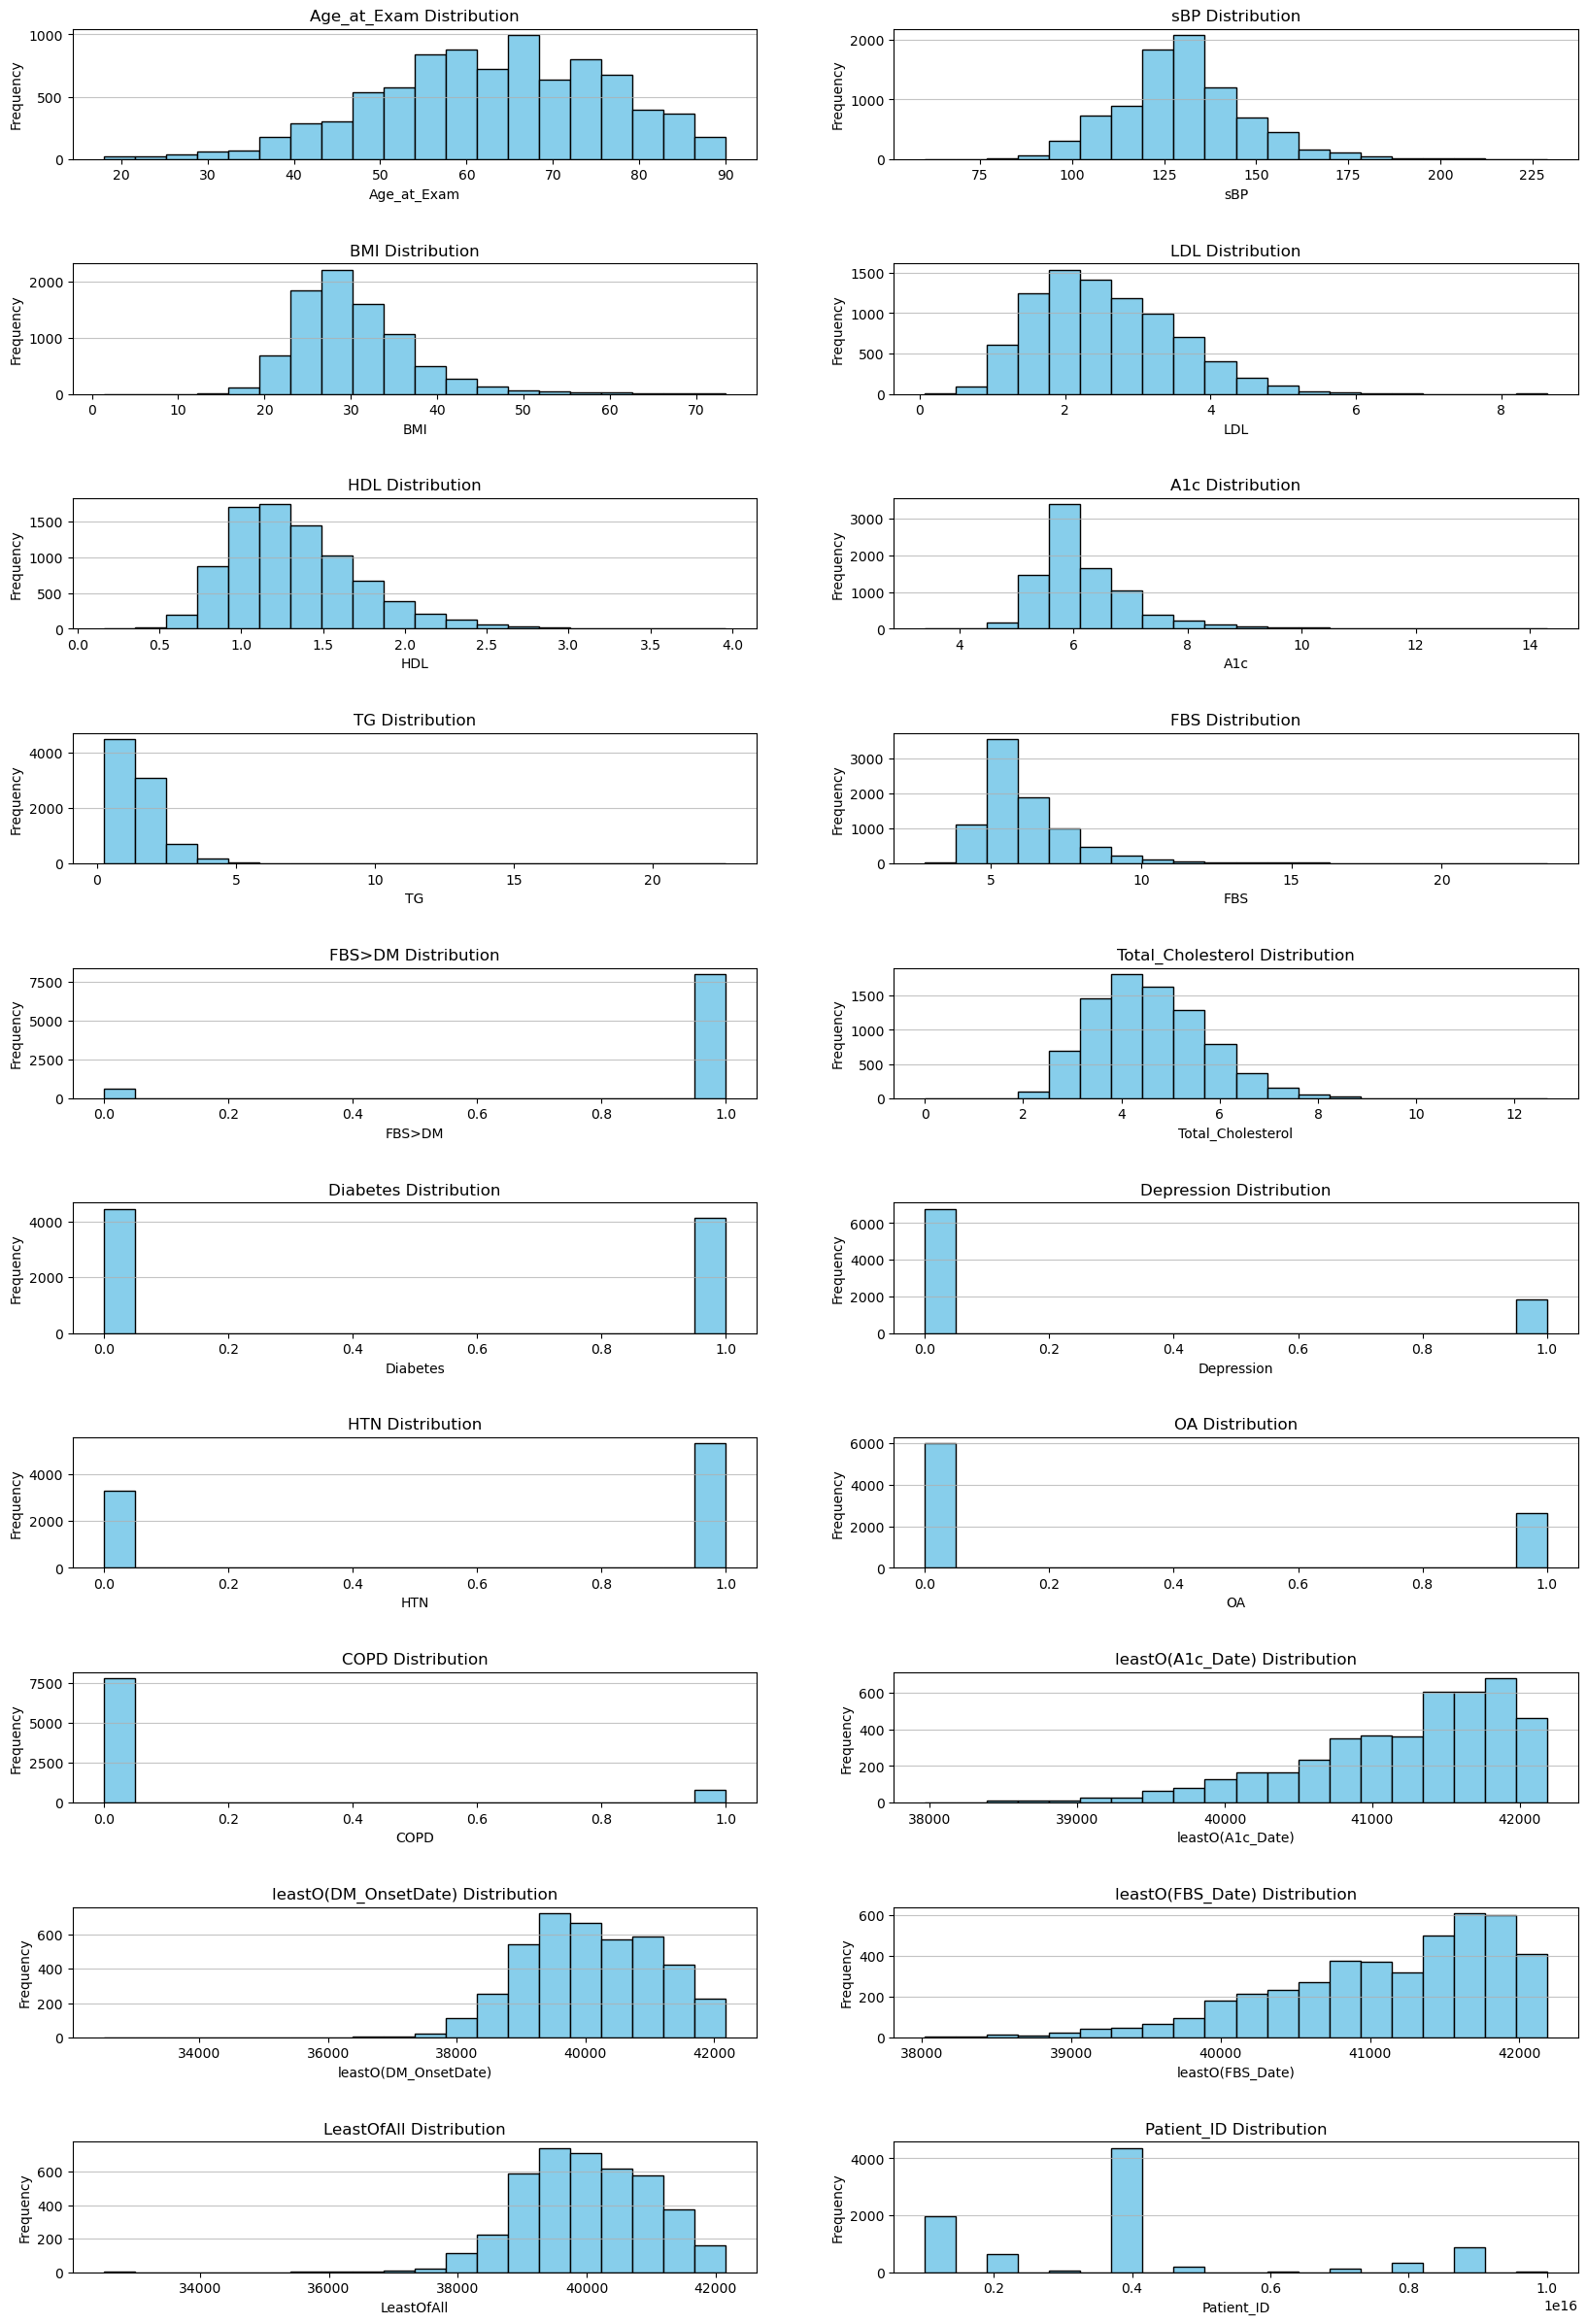

In [42]:
# Get the list of column names (excluding non-numeric columns)
numeric_columns = df.select_dtypes(include=['number']).columns

# Calculate the number of rows and columns for the grid
num_columns_per_row = 2
num_rows = (len(numeric_columns) + num_columns_per_row - 1) // num_columns_per_row

# Create a grid of histograms
fig, axes = plt.subplots(num_rows, num_columns_per_row, figsize=(20, 30))
fig.subplots_adjust(hspace=0.8)

for i, column in enumerate(numeric_columns):
    row = i // num_columns_per_row
    col = i % num_columns_per_row

    ax = axes[row, col]
    ax.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'{column} Distribution')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', alpha=0.75)

# Remove any empty subplots
for i in range(len(numeric_columns), num_rows * num_columns_per_row):
    fig.delaxes(axes.flatten()[i])

plt.show()

In [43]:
# Print summary statistics
print(df.describe())

       Age_at_Exam          sBP                       sBP_Date          BMI  \
count  8602.000000  8598.000000                           8602  8602.000000   
mean     62.827249   130.021633  2012-07-07 06:14:28.821204224    30.320669   
min      18.000000    60.000000            2004-03-18 00:00:00     1.376352   
25%      54.000000   120.000000            2011-03-30 06:00:00    25.770471   
50%      63.000000   130.000000            2012-12-18 00:00:00    29.200000   
75%      73.000000   140.000000            2014-03-11 00:00:00    33.700000   
max      90.000000   229.000000            2015-06-30 00:00:00    73.400000   
std      13.307028    16.914285                            NaN     6.856371   

                            BMI_Date          LDL  \
count                           8602  8550.000000   
mean   2012-07-03 05:35:48.616600832     2.562384   
min              2004-01-07 00:00:00     0.070000   
25%              2011-03-22 00:00:00     1.840000   
50%              2012-1

<Axes: >

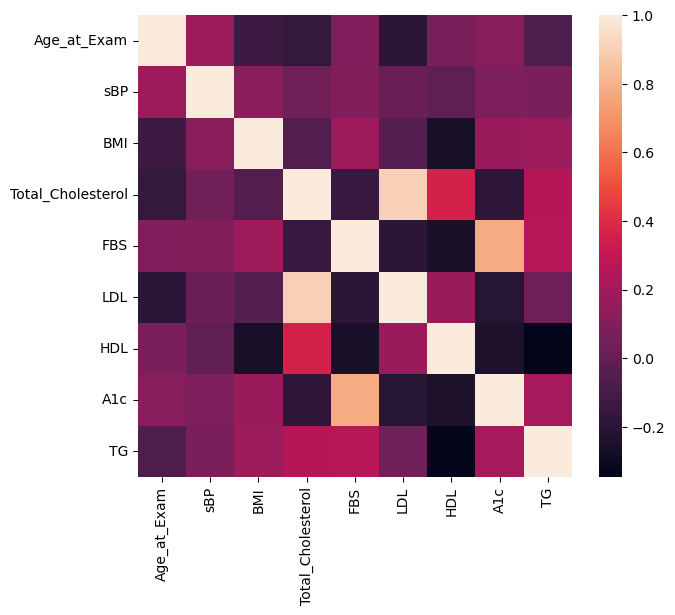

In [44]:
# Display multicollineary heatmap plot of continuous variables
columns_to_check = ["Age_at_Exam","sBP","BMI","Total_Cholesterol","FBS","LDL","HDL", "A1c", "TG"]

plt.figure(figsize=(7,6))
sns.heatmap(df[columns_to_check].corr())

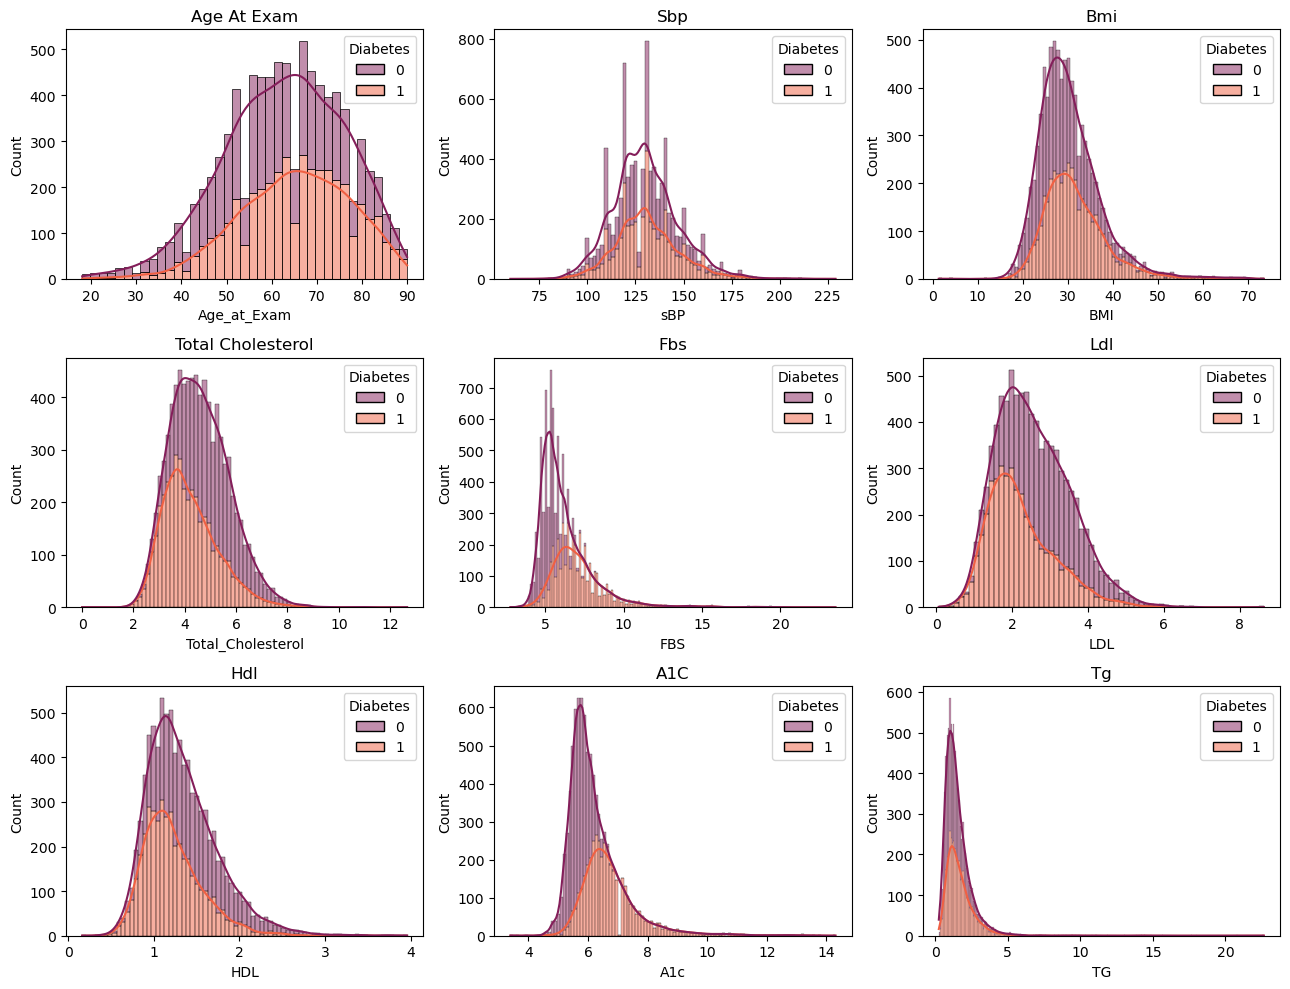

In [45]:
# Updating the list of meaningful columns based on the available columns in the dataset
selected_columns_for_analysis = ["Age_at_Exam","sBP","BMI","Total_Cholesterol","FBS","LDL","HDL", "A1c", "TG"]

# Creating a grid of subplots with 3 rows and 3 columns
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(13, 10))

# Looping over each selected feature to create a subplot for each
for i, column in enumerate(selected_columns_for_analysis):
    # Calculate the position for the subplot; x is the row index and y is the column index
    x = i // 3
    y = i % 3

    # Plotting a histogram of the feature split by the 'readmitted' class
    sns.histplot(df, x=column, hue='Diabetes', kde=True, palette='rocket', ax=axs[x][y],
                 multiple='stack')
    axs[x][y].set_title(column.replace('_', ' ').title())

# Adjusting the layout and display all the subplots
plt.tight_layout()
plt.show()


In [48]:
# Create new columns to indicate whether a patient was prescribed HTN medications or corticosteroids
df['Had_HTN_Medications'] = df['Hypertension_Medications'].apply(lambda x: 'yes' if pd.notna(x) else 'no')
df['Had_Corticosteroids'] = df['Corticosteroids'].apply(lambda x: 'yes' if pd.notna(x) else 'no')

<Axes: xlabel='Had_HTN_Medications', ylabel='count'>

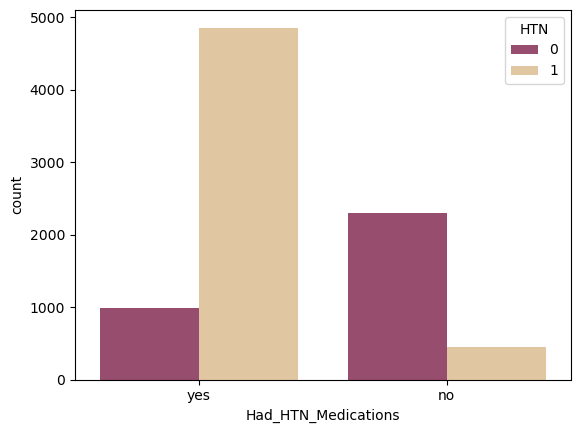

In [49]:
sns.countplot(df, x = 'Had_HTN_Medications', hue = 'HTN', palette = colors)

<Axes: xlabel='Had_Corticosteroids', ylabel='count'>

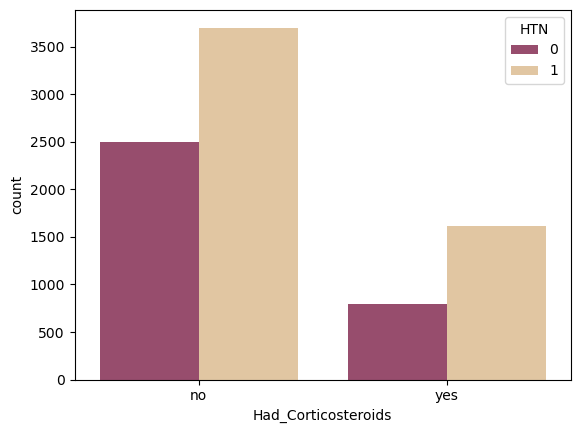

In [50]:
sns.countplot(df, x = 'Had_Corticosteroids', hue = 'HTN', palette = colors)

In [51]:
# Converting descriptive categories back to numerical variables
df['Had_HTN_Medications'].replace({'no' : 0, 'yes': 1}, inplace = True)
df['Had_Corticosteroids'].replace({'no' : 0, 'yes': 1}, inplace = True)
df['Sex'].replace({'Female' : 0, 'Male' : 1}, inplace = True)

In [52]:
pd.set_option('display.max_columns', None)

print(df.head())

      Age_at_Exam    sBP   sBP_Date        BMI   BMI_Date   LDL   LDL_Date  \
5193           63  133.0 2012-07-31  30.900000 2011-12-01  1.65 2012-06-01   
4875           75  170.0 2012-10-23  32.500000 2012-06-14  3.98 2012-11-07   
9778           49  130.0 2007-04-17  33.400000 2007-04-17  3.24 2007-05-03   
8014           66  112.0 2010-05-13  23.600000 2010-03-31  1.62 2011-03-11   
7322           84  128.0 2011-01-24  30.677753 2011-10-24  2.13 2011-02-15   

       HDL   HDL_Date  A1c   A1c_Date    TG    TG_Date  FBS   FBS_Date  \
5193   NaN        NaT  6.1 2012-06-01  0.76 2012-06-01  5.6 2012-06-01   
4875  1.66 2012-11-07  6.6 2012-11-07  2.33 2012-11-07  7.2 2012-11-07   
9778  1.88 2007-05-03  6.6 2007-05-03  1.16 2007-05-03  7.5 2007-05-03   
8014  1.34 2010-04-01  5.8 2010-04-01  1.53 2010-04-01  6.2 2010-04-01   
7322  1.81 2011-02-15  7.6 2011-02-15   NaN        NaT  5.3 2011-02-15   

      FBS>DM  Total_Cholesterol Total_Cholesterol_Lab_Date  Diabetes  \
5193       1  

## 3.1 Feature Selection

In [53]:
# Create list of numerical, categorical, multinomial features
# Remove FBS due to collinearity with A1c and literature showing A1c is accurate and longer-term measure compared to FBS
# Remove Total_Cholesterol due to collinearity with LDL and HDL
# Remove dates due to uninformative
target_column = 'Diabetes'
binary_columns = ['Depression', 'HTN', 'OA', 'COPD', 'Sex', 'Had_HTN_Medications', 'Had_Corticosteroids']
continuous_columns = ['Age_at_Exam', 'sBP', 'BMI', 'LDL', 'HDL', 'A1c', 'TG']

In [54]:
# Descriptive statistics
df[continuous_columns].describe()

,Age_at_Exam,sBP,BMI,LDL,HDL,A1c,TG
count,8602.000000,8598.000000,8602.000000,8550.000000,8534.000000,8602.000000,8551.000000
mean,62.827249,130.021633,30.320669,2.562384,1.332619,6.226272,1.540912
std,13.307028,16.914285,6.856371,0.958005,0.408344,0.946842,1.028655
min,18.000000,60.000000,1.376352,0.070000,0.160000,3.400000,0.240000
25%,54.000000,120.000000,25.770471,1.840000,1.040000,5.600000,0.950000
50%,63.000000,130.000000,29.200000,2.430000,1.260000,6.000000,1.310000
75%,73.000000,140.000000,33.700000,3.190000,1.560000,6.600000,1.870000
max,90.000000,229.000000,73.400000,8.630000,3.960000,14.300000,22.640000


In [55]:
# Descriptive statistics
df[binary_columns].describe()

,Depression,HTN,OA,COPD,Sex,Had_HTN_Medications,Had_Corticosteroids
count,8602.000000,8602.000000,8602.00000,8602.000000,8602.000000,8602.000000,8602.000000
mean,0.211462,0.617415,0.30551,0.095792,0.463729,0.680307,0.279354
std,0.408369,0.486047,0.46065,0.294322,0.498712,0.466385,0.448708
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,1.00000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [56]:
# Descriptive statistics
df[target_column].describe()

count    8602.000000
mean        0.481516
std         0.499687
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Diabetes, dtype: float64

## 3.2 Subsetting Data for Train/Test and Validation (85:15)

In [132]:
# Subset 15% of original dataframe for validation of the best-performing model
# Remaining 85% of dataframe used for training/testing
df_model = df.sample(frac = 0.85, random_state = 99)
df_valid = df.drop(df_model.index)

In [133]:
df_model.shape

(7312, 45)

In [134]:
df_valid.shape

(1290, 45)

# 4 Machine Learning (Making the Machine Learn)

## 4.1 Machine Learning Pipeline

In [60]:
# Define pipelines for numerical and categorical features

# Continuous pipeline
#   1.  Implement MICE imputation for missing values
#   2.  Scale values using StandardScaler
continuous_pipeline = Pipeline(steps = [
    ('imputer', IterativeImputer(max_iter = 10, random_state = 42)),
    ('scaler', StandardScaler())
])

# Binary pipeline
#   1.  Implement MICE imputation for missing values
binary_pipeline = Pipeline(steps = [
    ('imputer', IterativeImputer(max_iter = 10, random_state = 42))
])

# Define pipeline to transform numerical and categorical feature columns with respective pipelines
all_columns_transform = ColumnTransformer(transformers = [
    ('continuous_pipeline', continuous_pipeline, continuous_columns),
    ('binary_pipeline', binary_pipeline, binary_columns)
],
                                        remainder = 'passthrough',
                                        n_jobs = -1
                                        )
continuous_columns_transform = ColumnTransformer(transformers = [
    ('continuous_pipeline', continuous_pipeline, continuous_columns)
],
                                        remainder = 'passthrough',
                                        n_jobs = -1
                                        )
binary_columns_transform = ColumnTransformer(transformers = [
    ('binary_pipeline', binary_pipeline, binary_columns)
],
                                        remainder = 'passthrough',
                                        n_jobs = -1
                                        )

In [61]:
# Define classifiers
logreg = LogisticRegression(max_iter = 1000,
                            random_state = 42)
dt = DecisionTreeClassifier(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
xgb = XGBClassifier(random_state = 42)
svm = SVC(random_state = 42)
gnb = GaussianNB()
bnb = BernoulliNB()

# Define hyperparameter grids for each classifier
# Logistic Regression (logreg)
param_grid_logreg = {
    'classifier': [logreg],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}
# Decision Tree (dt)
param_grid_dt = {
    'classifier': [dt],
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__min_samples_leaf': [5, 10, 15, 20],
}
# Random Forest (rf)
param_grid_rf = {
    'classifier': [rf],
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_leaf': [15, 20, 25],
}
# XGBoost (xgb)
param_grid_xgb = {
    'classifier': [xgb],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__reg_lambda': [0, 1, 5],
    'classifier__reg_alpha': [0, 1, 5]
}
# Support Vector Machines (svm)
param_grid_svm = {
    'classifier': [svm],
    'classifier__kernel': ['rbf'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__gamma': [0.01, 1, 10],
    'classifier__class_weight': [None, 'balanced']
}
# Gaussian Naive Bayes (gnb)
param_grid_gnb = {
    'classifier': [gnb],
    'classifier__var_smoothing': np.logspace(0, -9, num = 10)
}
# Bernoulli Naive Bayes (bnb)
param_grid_bnb = {
    'classifier': [bnb],
    'classifier__alpha': np.logspace(0, -9, num = 10)
}

In [62]:
# Specify which classifiers are using all features or only continuous/binary features
use_all_features = [logreg, dt, rf, xgb, svm]
use_continuous_features = [gnb]
use_binary_features = [bnb]

In [63]:
# Remove FBS due to collinearity with A1c and literature showing A1c is accurate and longer-term measure compared to FBS
# Remove Total_Cholesterol due to collinearity with LDL and HDL
# Remove dates due to uninformative
dropping_columns = ['FBS', 'Total_Cholesterol', 'sBP_Date', 'Patient_ID', 'BMI_Date', 'LDL_Date', 'HDL_Date', 'A1c_Date', 'TG_Date', 'FBS_Date', 'FBS>DM', 'Total_Cholesterol_Lab_Date', 'DM_OnsetDate', 'Depression_OnsetDate', 'HTN_OnsetDate', 'OA_OnsetDate', 'COPD_Date', 'Hypertension_Medications', 'Hypertension_Medications_First_Instance', 'Corticosteroids', 'Corticosteroids_first_instance', 'leastO(A1c_Date)', 'leastO(DM_OnsetDate)','leastO(FBS_Date)', 'LeastOfAll', 'A1C_BEF_DM', 'FBS_BEF_DM', 'DM_Onset_Revised','DM_Onset_Revised_1YrPrior','DIABETES']
df_model = df_model.drop(columns=dropping_columns, axis=1)

In [64]:
df_model

,Age_at_Exam,sBP,BMI,LDL,HDL,A1c,TG,Diabetes,Depression,HTN,OA,COPD,Sex,Had_HTN_Medications,Had_Corticosteroids
354,52,157.0,32.530000,2.55,1.06,5.8,1.23,0,0,1,0,0,1,1,0
4433,52,142.0,45.260000,1.87,1.40,8.4,1.40,1,0,1,0,0,1,1,0
1471,55,159.0,26.775510,2.04,0.98,5.8,1.00,0,1,0,0,0,1,0,0
3919,67,130.0,30.000000,2.70,1.00,5.7,1.13,0,0,1,1,0,1,0,0
2784,42,129.0,43.200000,1.74,1.18,8.9,1.03,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7008,85,128.0,30.750000,3.99,1.59,5.6,0.79,0,0,1,0,1,0,1,1
31,74,115.0,28.225277,0.77,1.07,7.2,1.69,1,0,1,1,0,1,1,0
2233,73,129.0,31.300000,1.42,0.88,6.1,2.06,1,0,1,0,0,1,1,1
8280,80,128.0,26.700000,1.60,1.25,6.2,1.16,0,0,1,0,0,1,1,1


In [65]:
# Splitting the remaining 85% of the original dataframe into training and testing sets (70:30 split)

# Taking 70% of the subsetted dataframe for training
train_df = df_model.sample(frac = 0.7, random_state = 99)

# Removing the training data from the original dataset to get the combined validation and test data
test_df = df_model.drop(train_df.index)

In [66]:
train_df.shape

(5118, 15)

In [67]:
test_df.shape

(2194, 15)

In [69]:
# Extract the 'Diabetes' column as the target variable for training and testing
Y_train = train_df['Diabetes']
Y_test = test_df['Diabetes']

# Extract the features (excluding 'Diabetes') for training and testing
X_train = train_df.drop('Diabetes', axis=1)
X_test = test_df.drop('Diabetes', axis=1)

## 4.2 Perform Hyperparameter Tuning with 5-Fold Cross-Validation (CV)

In [94]:
# List of classifiers and their param_grids
classifiers = [logreg, dt, rf, xgb, svm, gnb, bnb]
param_grids = [param_grid_logreg, param_grid_dt, param_grid_rf, param_grid_xgb, param_grid_svm, param_grid_gnb, param_grid_bnb]

# Cross-Validation using K-Folds (k = 5)
k = 5

# Results dictionary to store the best parameters and scores for each classifier
results = {}

# Iterate over classifiers and their param_grids
for classifier, param_grid in zip(classifiers, param_grids):
    # Create a new pipeline for each classifier
    if classifier in use_all_features:
        pipeline = Pipeline(steps=[
            ('column_transform', all_columns_transform),
            ('classifier', classifier)
        ])

        # Initiate grid search using F1 scoring as tuning metric
        cv = GridSearchCV(pipeline, param_grid, cv=k, scoring='f1')

        # Fit the grid search on the training data
        cv.fit(X_train, Y_train)

        # Store the results in the dictionary
        results[classifier.__class__.__name__] = {
            'best_params': cv.best_params_,
            'best_score': cv.best_score_,
            'classifier': cv.best_estimator_  # Store the best estimator
        }

    elif classifier in use_continuous_features:
        pipeline = Pipeline(steps=[
            ('column_transform', continuous_columns_transform),
            ('classifier', classifier)
        ])

        # Initiate grid search using F1 scoring as tuning metric
        cv = GridSearchCV(pipeline, param_grid, cv=k, scoring='f1')

        # Fit the grid search on the training data
        cv.fit(X_train[continuous_columns], Y_train)

        # Store the results in the dictionary
        results[classifier.__class__.__name__] = {
            'best_params': cv.best_params_,
            'best_score': cv.best_score_,
            'classifier': cv.best_estimator_  # Store the best estimator
        }

    elif classifier in use_binary_features:
        pipeline = Pipeline(steps=[
            ('column_transform', binary_columns_transform),
            ('classifier', classifier)
        ])

        # Initiate grid search using F1 scoring as tuning metric
        cv = GridSearchCV(pipeline, param_grid, cv=k, scoring='f1')

        # Fit the grid search on the training data
        cv.fit(X_train[binary_columns], Y_train)

        # Store the results in the dictionary
        results[classifier.__class__.__name__] = {
            'best_params': cv.best_params_,
            'best_score': cv.best_score_,
            'classifier': cv.best_estimator_  # Store the best estimator
        }

## 4.3 Results of 5-Fold CV Hyperparameter Tuning

### 4.3.1 Metrics of Classifiers Using All Features

#### 4.3.1.1 Receiver Opertaing Characteristic Curve (ROC)

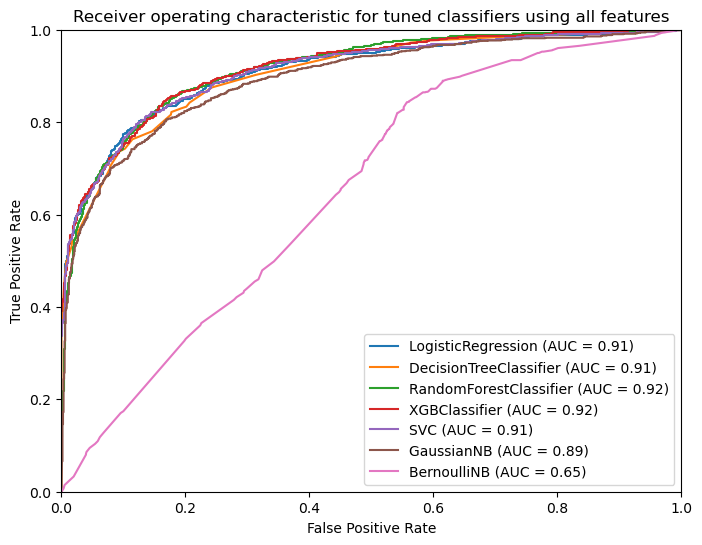

In [95]:
# ROC CURVE PLOT FOR ALL FEATURES AND CLASSIFIERS
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate over the tuned classifiers and plot ROC curve for each
for classifier_name, result in results.items():
    # Get the best estimator from the results
    best_estimator = result['classifier']

    # Plot ROC curve
    roc_curve_display = RocCurveDisplay.from_estimator(best_estimator, X_test, Y_test, name=classifier_name, ax=ax)

# Add a legend
ax.legend()

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for tuned classifiers using all features')
plt.ylim(0.0,1)
plt.xlim(0.0,1)

# Display the plot
plt.show()

#### 4.3.1.2 Confusion Matrices

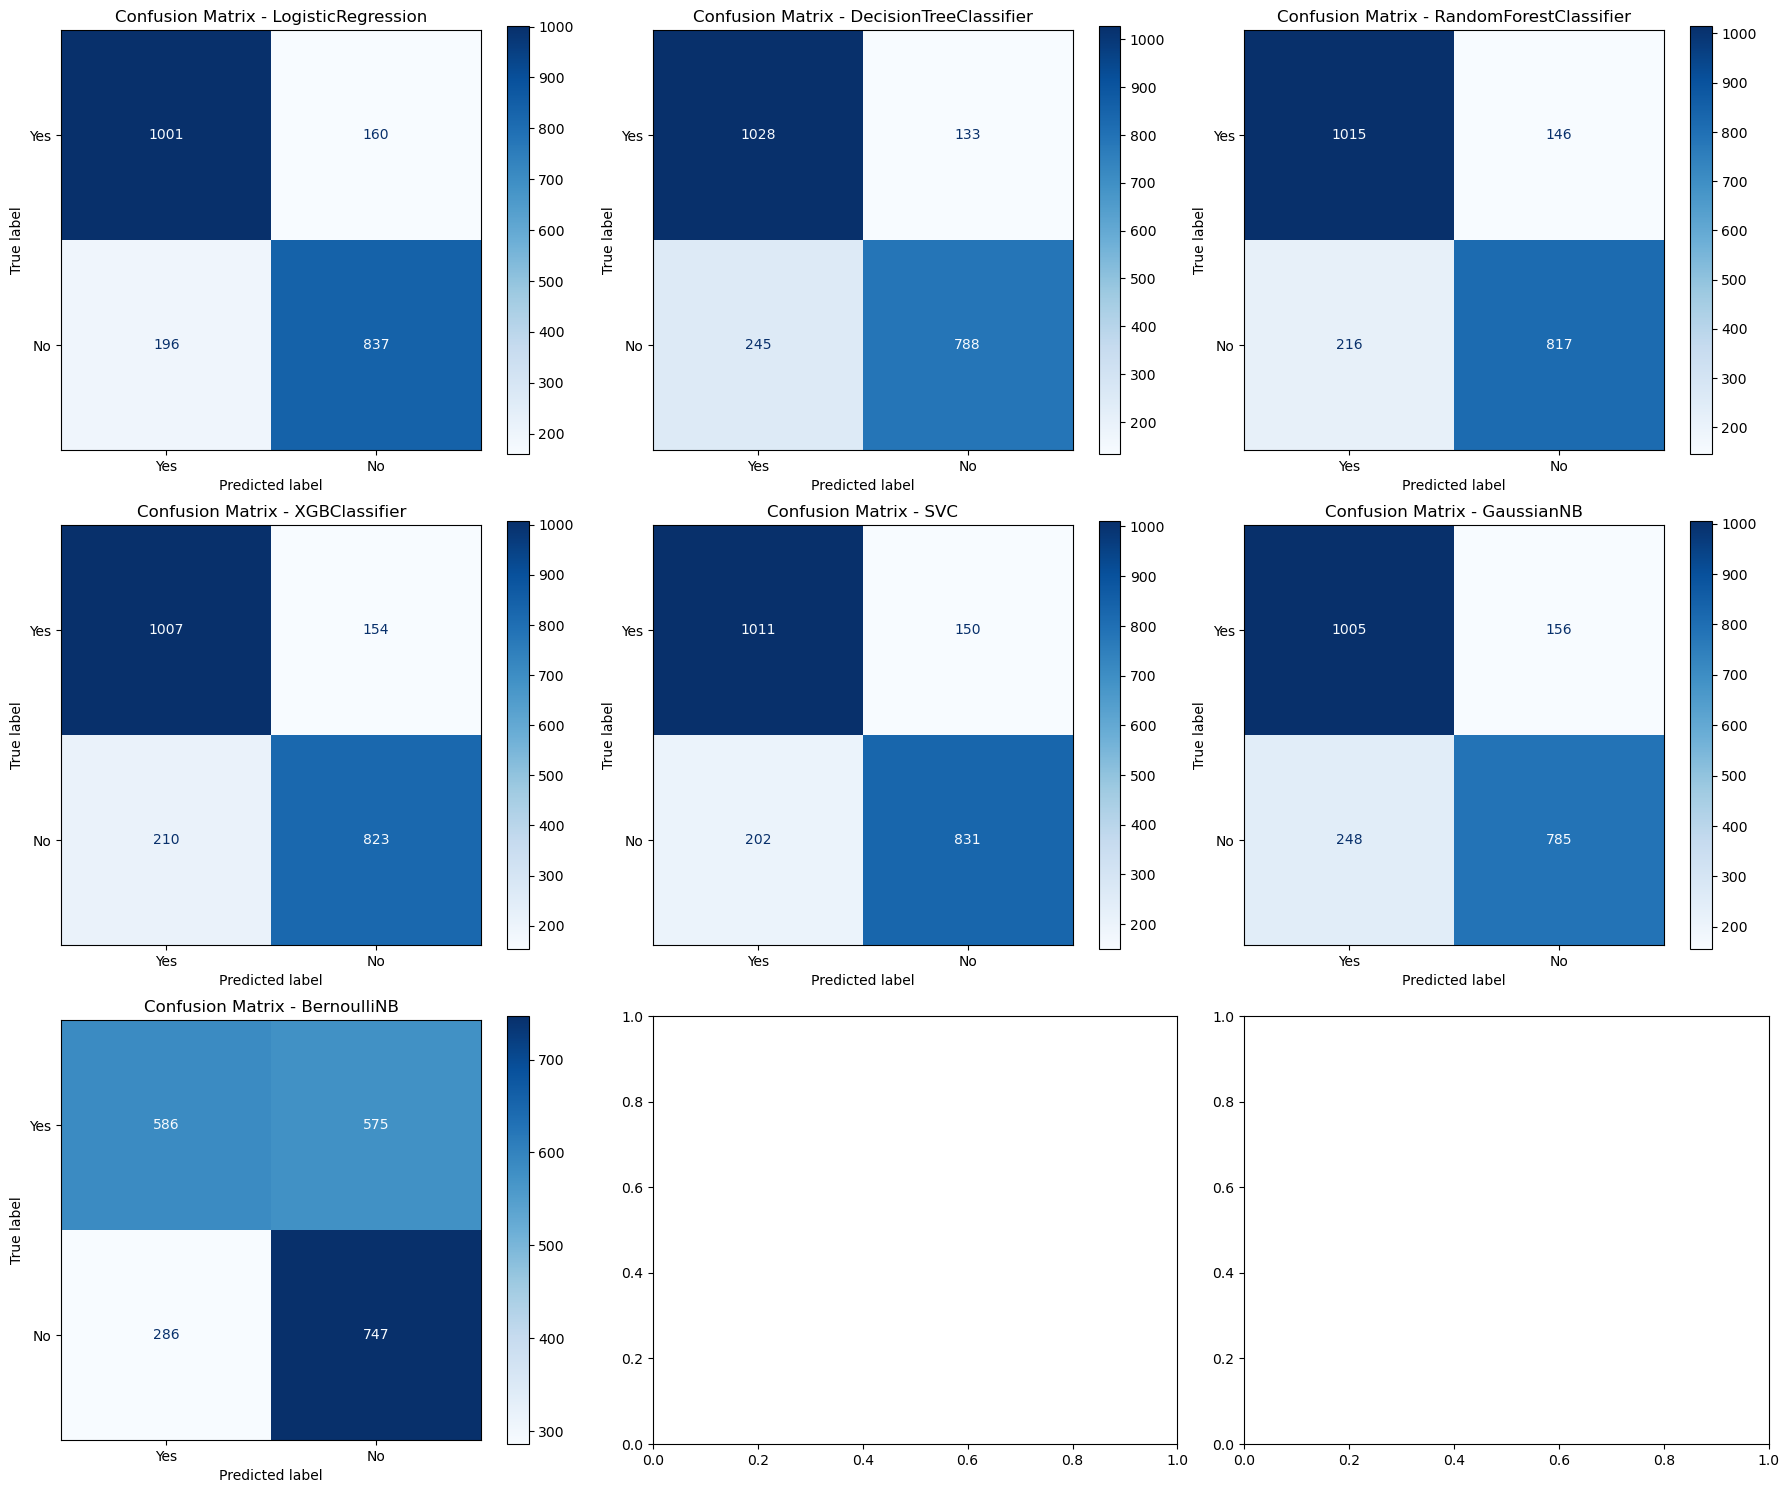

In [96]:
# CONFUSION MATRICES FOR ALL FEATURES AND CLASSIFIERS
# Create subplots for individual confusion matrices
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))

# Iterate over the tuned classifiers and plot confusion matrix for each
for i, (classifier_name, result) in enumerate(results.items()):
    # Get the best estimator from the results
    best_estimator = result['classifier']

    # Calculate predictions on the test set
    y_pred = best_estimator.predict(X_test)

    # Plot confusion matrix
    ax = axes[i // 3, i % 3]
    confusion_matrix_display = ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, Y_test, ax=ax, cmap=plt.cm.Blues, display_labels=["Yes", "No"])
    ax.set_title(f'Confusion Matrix - {classifier_name}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

#### 4.3.1.3 Classification Reports

In [97]:
# Print the classification report for each tuned classifier
for classifier_name, result in results.items():
    # Get the best estimator from the results
    best_estimator = result['classifier']

    # Calculate predictions on the test set
    Y_pred = best_estimator.predict(X_test)

    # Print the classification report
    print(f"Classification Report for {classifier_name}:\n{classification_report(Y_test, Y_pred)}\n")

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1161
           1       0.84      0.81      0.82      1033

    accuracy                           0.84      2194
   macro avg       0.84      0.84      0.84      2194
weighted avg       0.84      0.84      0.84      2194


Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.81      0.89      0.84      1161
           1       0.86      0.76      0.81      1033

    accuracy                           0.83      2194
   macro avg       0.83      0.82      0.83      2194
weighted avg       0.83      0.83      0.83      2194


Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1161
           1       0.85      0.79      0.82      1033

    accuracy                      

#### 4.3.1.4 Selected Hyperparameters for Each Classifier After 5-Fold CV Tuning

In [98]:
# Print tuned hyperparameters for each classifier
results['LogisticRegression']['best_params']

{'classifier': LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=42,
                    solver='liblinear'),
 'classifier__C': 1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [99]:
results['DecisionTreeClassifier']['best_params']

{'classifier': DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42),
 'classifier__max_depth': 5,
 'classifier__min_samples_leaf': 10}

In [100]:
results['RandomForestClassifier']['best_params']

{'classifier': RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=200,
                        random_state=42),
 'classifier__max_depth': 15,
 'classifier__min_samples_leaf': 15,
 'classifier__n_estimators': 200}

In [101]:
results['XGBClassifier']['best_params']

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0.2, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 'classifier__gamma': 0.2,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 100,
 'classifier__reg_alpha': 1,
 'classifier__reg_lambda': 5}

In [102]:
results['SVC']['best_params']

{'classifier': SVC(C=1, class_weight='balanced', gamma=0.01, random_state=42),
 'classifier__C': 1,
 'classifier__class_weight': 'balanced',
 'classifier__gamma': 0.01,
 'classifier__kernel': 'rbf'}

In [103]:
results['GaussianNB']['best_params']

{'classifier': GaussianNB(var_smoothing=0.001),
 'classifier__var_smoothing': 0.001}

In [104]:
results['BernoulliNB']['best_params']

{'classifier': BernoulliNB(), 'classifier__alpha': 1.0}

#### 4.3.1.5 Analysis of Combined Naive Bayes (CNB) Classifier

##### 4.3.1.5.1 CNB on Training Data

AUC :  0.8099325314794191
Accuracy :  0.8112543962485346
Confusion Matrix:
[[2244  427]
 [ 539 1908]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      2671
           1       0.82      0.78      0.80      2447

    accuracy                           0.81      5118
   macro avg       0.81      0.81      0.81      5118
weighted avg       0.81      0.81      0.81      5118


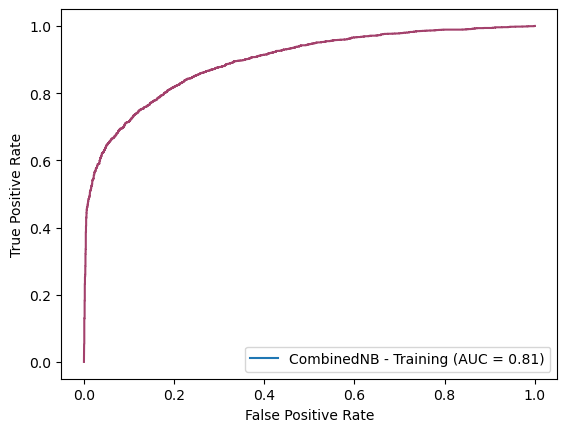

In [106]:
# Evaluating Combined Naive Bayes Model on Training Data
# Define tuned Naive Bayes Models
best_gnb = GaussianNB(var_smoothing=1e-06)
best_bnb = BernoulliNB(alpha=1)

# Training a Gaussian Naive Bayes model for continuous variables
best_gnb_fit = best_gnb.fit(continuous_columns_transform.fit_transform(X_train[continuous_columns]), Y_train)

# Training a Bernoulli Naive Bayes model for binary variables
best_bnb_fit = best_bnb.fit(binary_columns_transform.fit_transform(X_train[binary_columns]), Y_train)

# Getting joint log probabilities for each model
gnb_log_pred = best_gnb_fit.predict_joint_log_proba(continuous_columns_transform.fit_transform(X_train[continuous_columns]))
bnb_log_pred = best_bnb_fit.predict_joint_log_proba(binary_columns_transform.fit_transform(X_train[binary_columns]))

# Combine the log probabilities
y_hat_prob = gnb_log_pred + bnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model using custom functions
conf_matrix, class_report, auc, acc = get_scores(Y_train, y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(Y_train, y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='CombinedNB - Training')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')

##### 4.3.1.5.2 CNB on Testing Data

AUC :  0.8045343459130352
Accuracy :  0.8062898814949864
Confusion Matrix:
[[969 192]
 [233 800]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1161
           1       0.81      0.77      0.79      1033

    accuracy                           0.81      2194
   macro avg       0.81      0.80      0.81      2194
weighted avg       0.81      0.81      0.81      2194


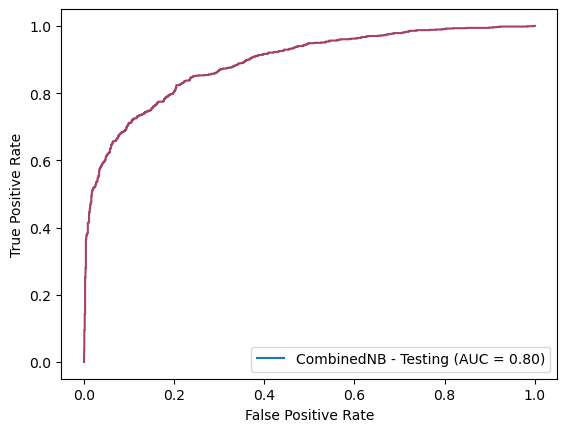

In [108]:
# Getting joint log probabilities for each model
gnb_log_pred = best_gnb_fit.predict_joint_log_proba(continuous_columns_transform.fit_transform(X_test[continuous_columns]))
bnb_log_pred = best_bnb_fit.predict_joint_log_proba(binary_columns_transform.fit_transform(X_test[binary_columns]))

# Combine the log probabilities
y_hat_prob = gnb_log_pred + bnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model using custom functions
conf_matrix, class_report, auc, acc = get_scores(Y_test, y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='CombinedNB - Testing')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')

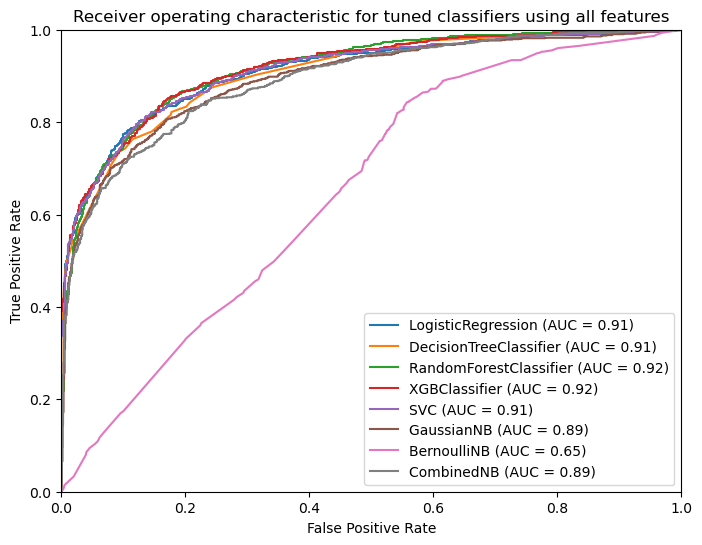

In [109]:
# ROC CURVE PLOT FOR ALL FEATURES AND CLASSIFIERS
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate over the tuned classifiers and plot ROC curve for each
for classifier_name, result in results.items():
    # Get the best estimator from the results
    best_estimator = result['classifier']

    # Plot ROC curve
    roc_curve_display = RocCurveDisplay.from_estimator(best_estimator, X_test, Y_test, name=classifier_name, ax=ax)

roc_curve_display = RocCurveDisplay.from_predictions(Y_test, y_hat_prob[:, 1], name='CombinedNB', ax=ax)

# Add a legend
ax.legend()

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for tuned classifiers using all features')
plt.ylim(0.0,1)
plt.xlim(0.0,1)

# Display the plot
plt.show()

#### 4.3.1.6 Feature Importance from Classifiers Using All Features

In [110]:
# Extract the features (excluding 'Diabetes') for training and testing
X_train = train_df.drop('Diabetes', axis=1)
X_test = test_df.drop('Diabetes', axis=1)

# Extract the 'Diabetes' column as the target variable for training and testing
Y_train = train_df['Diabetes']
Y_test = test_df['Diabetes']

In [111]:
# Transform training and testing data separately
X_train = all_columns_transform.fit_transform(X_train)
X_test = all_columns_transform.fit_transform(X_test)

/Users/andyt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[17:03:14] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



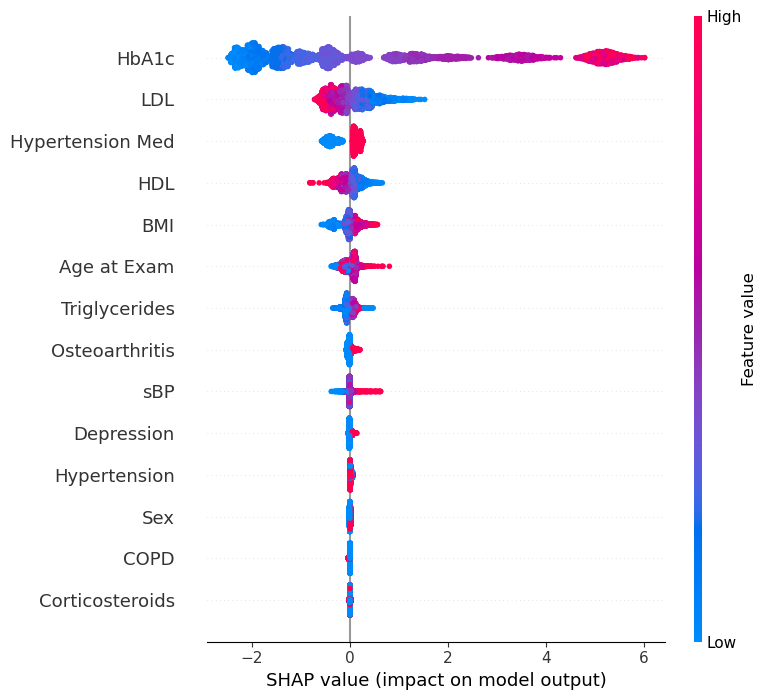

In [112]:
# Assuming 'model' is your trained model and 'X' is your feature matrix - USED IN MANUSCRIPT
xgb_model = XGBClassifier(random_state = 42,
                          gamma = 0.2,
                          learning_rate = 0.1,
                          max_depth = 3,
                          n_estimators = 100,
                          reg_alpha = 1,
                          reg_lambda = 5)

xgb_model.fit(X_train, Y_train)

explainer = shap.Explainer(xgb_model) 
shap_values = explainer(X_train)
shap.summary_plot(shap_values, max_display=30, feature_names=['Age at Exam', 'sBP', 'BMI', 'LDL', 'HDL', 'HbA1c', 'Triglycerides', 'Depression', 'Hypertension', 'Osteoarthritis', 'COPD', 'Sex', 'Hypertension Med', 'Corticosteroids'])

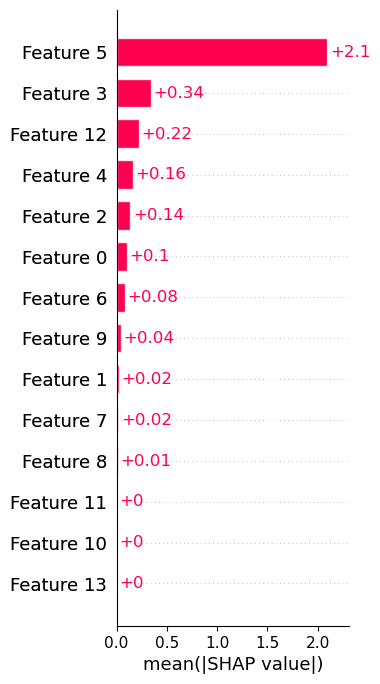

In [113]:
# USED IN MANUSCRIPT
shap.plots.bar(shap_values, max_display=30, show=False)
fig = plt.gcf()
fig.set_size_inches(3, 8)
plt.show()

In [114]:
# Display intercept and regression coefficients of the tuned model
logreg_intercept = results['LogisticRegression']['classifier'].named_steps['classifier'].intercept_
logreg_coefficients = results['LogisticRegression']['classifier'].named_steps['classifier'].coef_
print('The logistic regression intercept is: ' + str(logreg_intercept))
print('The logistic regression coefficients are: ' + str(logreg_coefficients))

The logistic regression intercept is: [-0.10731041]
The logistic regression coefficients are: [[-0.02915933  0.0591255   0.13145581 -0.49462251 -0.20962896  3.39585149
   0.09849161  0.13235629 -0.09811428  0.15985564 -0.15245283  0.04982216
   0.72479874 -0.02271121]]


In [115]:
logreg_model = sm.Logit(Y_train, sm.add_constant(X_train))
logreg_result = logreg_model.fit()

# Display coefficients and 95% confidence intervals
print('The logistic regression coefficients are:', logreg_result.params[1:])
print('The 95% confidence intervals are:')
print(logreg_result.conf_int(alpha=0.05).iloc[1:])

Optimization terminated successfully.
         Current function value: 0.354749
         Iterations 8
The logistic regression coefficients are: x1    -0.034283
x2     0.062009
x3     0.131414
x4    -0.496341
x5    -0.207763
x6     3.409107
x7     0.101035
x8     0.145306
x9    -0.117448
x10    0.174164
x11   -0.171236
x12    0.062379
x13    0.755617
x14   -0.030263
dtype: float64
The 95% confidence intervals are:
            0         1
x1  -0.133582  0.065015
x2  -0.024772  0.148790
x3   0.042084  0.220745
x4  -0.587403 -0.405280
x5  -0.309757 -0.105770
x6   3.191326  3.626888
x7   0.005597  0.196473
x8  -0.057063  0.347675
x9  -0.341366  0.106470
x10 -0.010594  0.358923
x11 -0.445732  0.103260
x12 -0.116929  0.241687
x13  0.514142  0.997092
x14 -0.213880  0.153353


Feature: Age_at_Exam, Score: 0.00042
Feature: sBP, Score: 0.00385
Feature: BMI, Score: 0.00469
Feature: LDL, Score: 0.05298
Feature: HDL, Score: 0.01899
Feature: A1c, Score: 0.90520
Feature: TG, Score: 0.00165
Feature: Depression, Score: 0.00000
Feature: HTN, Score: 0.00000
Feature: OA, Score: 0.00000
Feature: COPD, Score: 0.00000
Feature: Sex, Score: 0.00000
Feature: Had_HTN_Medications, Score: 0.01221
Feature: Had_Corticosteroids, Score: 0.00000


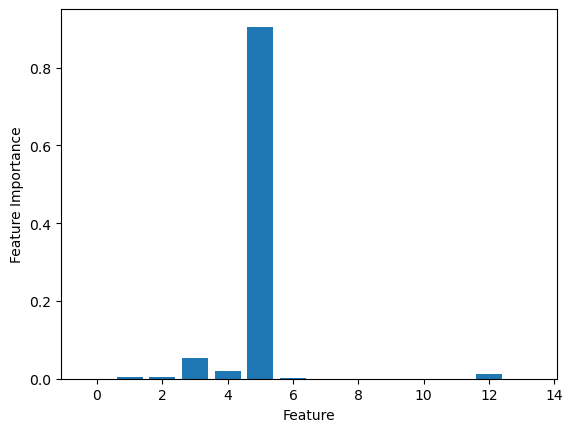

In [116]:
# Get Decision Tree feature importance
importance = results['DecisionTreeClassifier']['classifier'].named_steps['classifier'].feature_importances_
# Summarize feature importance
for count, value in enumerate(importance):
  print('Feature: ' + df[continuous_columns + binary_columns].columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

# 5 Artificial Neural Networks (ANNs)

## 5.1 ANN Pipeline and Data Preparation

In [117]:
# Define pipelines for numerical and categorical features

# Continuous pipeline
#   1.  Implement MICE imputation for missing values
#   2.  Scale values using StandardScaler
continuous_pipeline = Pipeline(steps = [
    ('imputer', IterativeImputer(max_iter = 10, random_state = 42)),
    ('scaler', StandardScaler())
])

# Binary pipeline
#   1.  Implement MICE imputation for missing values
binary_pipeline = Pipeline(steps = [
    ('imputer', IterativeImputer(max_iter = 10, random_state = 42))
])

# Define pipeline to transform numerical and categorical feature columns with respective pipelines
all_columns_transform = ColumnTransformer(transformers = [
    ('continuous_pipeline', continuous_pipeline, continuous_columns),
    ('binary_pipeline', binary_pipeline, binary_columns)
],
                                        remainder = 'passthrough',
                                        n_jobs = -1
                                        )

In [84]:
X_train.dtypes

Age_at_Exam              int64
sBP                    float64
BMI                    float64
LDL                    float64
HDL                    float64
A1c                    float64
TG                     float64
Depression               int64
HTN                      int64
OA                       int64
COPD                     int64
Sex                      int64
Had_HTN_Medications      int64
Had_Corticosteroids      int64
dtype: object

In [76]:
# Extract the features (excluding 'Diabetes') for training and testing
X_train_NN = train_df.drop('Diabetes', axis=1)
X_test_NN = test_df.drop('Diabetes', axis=1)

In [77]:
# Transform training and testing data separately
X_train_NN = all_columns_transform.fit_transform(X_train)
X_test_NN = all_columns_transform.fit_transform(X_test)

Y_train_NN = train_df['Diabetes'].to_numpy()
Y_test_NN = test_df['Diabetes'].to_numpy()

In [78]:
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

## 5.2 ANN Model #1 (2 Layers with Dropout)

### 5.2.1 Hyperparameter Tuning with Grid Search

In [ ]:
number_of_input_features = 14
epochs = 500

# Define the hyperparameter space
hyperparameter_space = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'number_of_hidden_units': [64, 128, 256],
    'dropout_probability': [0.2, 0.3, 0.4]
}

# Lists to store results for each set of hyperparameters
grid_search_results = []

# Grid Search
hyperparameter_combinations = list(itertools.product(*hyperparameter_space.values()))

for hyperparams_values in hyperparameter_combinations:
    # Create a dictionary with hyperparameters
    hyperparams = dict(zip(hyperparameter_space.keys(), hyperparams_values))

    # Create and train the model with the current set of hyperparameters
    model = nn.Sequential(
        nn.Linear(number_of_input_features, hyperparams['number_of_hidden_units']),
        nn.Tanh(),
        nn.Dropout(hyperparams['dropout_probability']),
        nn.Linear(hyperparams['number_of_hidden_units'], hyperparams['number_of_hidden_units']),
        nn.Tanh(),
        nn.Dropout(hyperparams['dropout_probability']),
        nn.Linear(hyperparams['number_of_hidden_units'], 1),
        nn.Sigmoid()
    )

    optimizer = Adam(model.parameters(), lr=hyperparams['learning_rate'])
    loss_fn = t.nn.BCELoss()

    # Prepare data loader
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_data_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)

    # Training loop
    for epoch in range(epochs):
        per_epoch_loss_list = []

        for batch_idx, (X, Y) in enumerate(train_data_loader):
            probs = model(X)
            loss = loss_fn(probs.view(-1), Y)
            per_epoch_loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate the model on test data
    with t.no_grad():
        model.eval()

        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        grid_search_results.append({
            'hyperparameters': hyperparams,
            'validation_accuracy': validation_accuracy
        })


### 5.2.2 Selected Hyperparameters for ANN Model #1 (2 Layers with Dropout)

In [ ]:
max_result = max(grid_search_results, key=lambda x: x['validation_accuracy'])
max_result

{'hyperparameters': {'learning_rate': 0.0001,
  'batch_size': 32,
  'number_of_hidden_units': 64,
  'dropout_probability': 0.3},
 'validation_accuracy': 0.8381950855255127}

### 5.2.3 Run Tuned ANN Model #1 (2 Layers with Dropout)

In [ ]:
number_of_input_features = 14
number_of_hidden_units = 256
epochs = 500
learning_rate = 0.0001
batch_size = 32
dropout_probability = 0.3

# Prepare the data
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model with drop-out
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),
    nn.Tanh(),
    nn.Dropout(dropout_probability),
    nn.Linear(number_of_hidden_units, number_of_hidden_units),
    nn.Tanh(),
    nn.Dropout(dropout_probability),
    nn.Linear(number_of_hidden_units, 1),
    nn.Sigmoid()  # Sigmoid activation for probability output due to binary outcome
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Binary Cross-Entropy Loss
loss_fn = t.nn.BCELoss()

train_accuracy_list = []  # List to store training accuracy
validation_accuracy_list = []  # List to store validation accuracy
train_loss_list = []  # List to store training loss
train_recall_list = [] # List to store training recall scores
validation_recall_list = [] # List to store validation recall scores
train_f1_list = [] # List to store training F1 scores
validation_f1_list = [] # List to store validation F1 scores

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []  # List to store losses for each epoch

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Calculate the loss
        loss = loss_fn(probs.view(-1), Y)
        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradients and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()
        predictions_train = (probs >= 0.5).type(t.LongTensor).view(-1).numpy()

        # Calculate precision, recall, and F1 score on train data
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(Y_train_tensor, prediction, average='binary')
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1)

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()
        predictions_test = (probs >= 0.5).type(t.LongTensor).view(-1).numpy()

        # Calculate precision, recall, and F1 score on validation data
        validation_precision, validation_recall, validation_f1, _ = precision_recall_fscore_support(Y_test_tensor, prediction, average='binary')
        validation_recall_list.append(validation_recall)
        validation_f1_list.append(validation_f1)

    

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

### 5.2.4 Metrics of Tuned ANN Model #1 (4 Layers with Dropout)

In [ ]:
last_validation_accuracy = validation_accuracy_list[-1]
last_validation_accuracy

0.8258888125419617

In [ ]:
last_validation_recall = validation_recall_list[-1]
last_validation_recall

0.7879961277831559

In [ ]:
last_validation_f1 = validation_f1_list[-1]
last_validation_f1

0.809950248756219

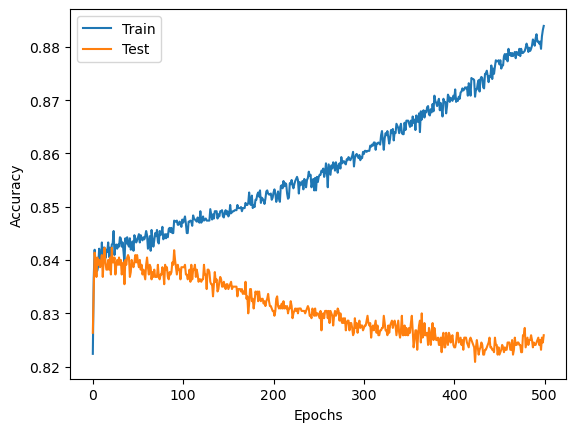

In [ ]:
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Test")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

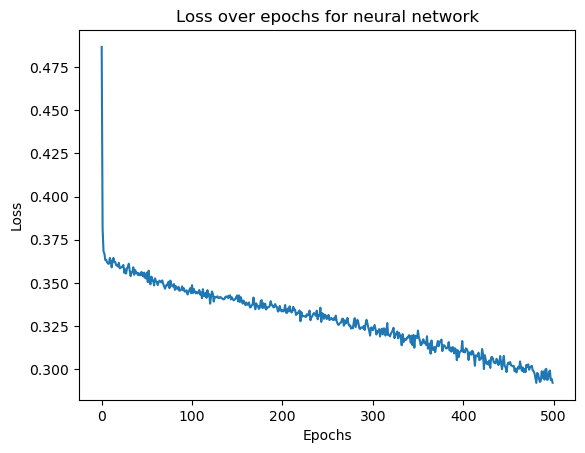

In [ ]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs for neural network')

# Display the plot
plt.show()

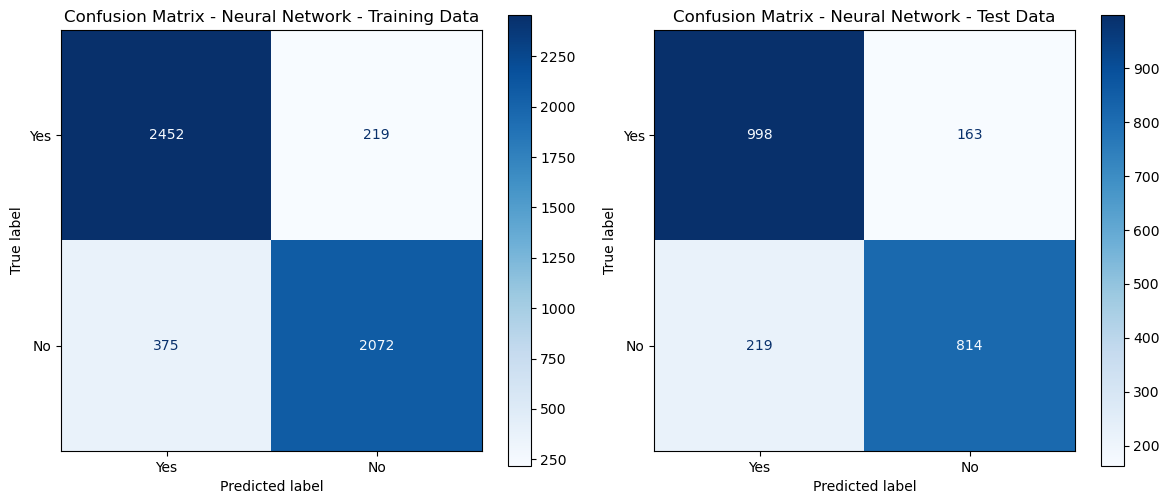

In [ ]:
# Convert true labels to numpy arrays
true_labels_train = Y_train_tensor.view(-1).numpy()
true_labels_test = Y_test_tensor.view(-1).numpy()

# Create subplots for individual confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax = axes[0]
confusion_matrix_display = ConfusionMatrixDisplay.from_predictions(true_labels_train, predictions_train, ax=ax, cmap=plt.cm.Blues, display_labels=["Yes", "No"])
ax.set_title(f'Confusion Matrix - Neural Network - Training Data')
ax = axes[1]
confusion_matrix_display = ConfusionMatrixDisplay.from_predictions(true_labels_test, predictions_test, ax=ax, cmap=plt.cm.Blues, display_labels=["Yes", "No"])
ax.set_title(f'Confusion Matrix - Neural Network - Test Data')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
print(f"Classification Report for Neural Network - Training Data:\n{classification_report(true_labels_train, predictions_train)}\n")
print(f"Classification Report for Neural Network - Test Data:\n{classification_report(true_labels_test, predictions_test)}")

Classification Report for Neural Network - Training Data:
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89      2671
         1.0       0.90      0.85      0.87      2447

    accuracy                           0.88      5118
   macro avg       0.89      0.88      0.88      5118
weighted avg       0.89      0.88      0.88      5118


Classification Report for Neural Network - Test Data:
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84      1161
         1.0       0.83      0.79      0.81      1033

    accuracy                           0.83      2194
   macro avg       0.83      0.82      0.82      2194
weighted avg       0.83      0.83      0.83      2194


In [ ]:
conf_matrix, class_report, auc, acc = get_scores(true_labels_test, predictions_test)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')

## 5.3 ANN Model #2 (2 Layers with L2 Regularization)

### 5.3.1 Hyperparameter Tuning with Grid Search

In [ ]:
number_of_input_features = 14
epochs = 500

# Define the hyperparameter space
hyperparameter_space = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'number_of_hidden_units': [64, 128, 256],
    'landa': [0.001, 0.01, 0.1]
}

# Lists to store results for each set of hyperparameters
grid_search_results = []

# Grid Search
hyperparameter_combinations = list(itertools.product(*hyperparameter_space.values()))

for hyperparams_values in hyperparameter_combinations:
    # Create a dictionary with hyperparameters
    hyperparams = dict(zip(hyperparameter_space.keys(), hyperparams_values))

    # Create and train the model with the current set of hyperparameters
    model = nn.Sequential(
        nn.Linear(number_of_input_features, hyperparams['number_of_hidden_units']),
        nn.Tanh(),
        nn.Linear(hyperparams['number_of_hidden_units'], hyperparams['number_of_hidden_units']),
        nn.Tanh(),
        nn.Linear(hyperparams['number_of_hidden_units'], 1),
        nn.Sigmoid()
    )

    optimizer = Adam(model.parameters(), lr=hyperparams['learning_rate'])
    loss_fn = t.nn.BCELoss()

    # Prepare data loader
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_data_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)

    # Training loop
    for epoch in range(epochs):
        per_epoch_loss_list = []

        for batch_idx, (X, Y) in enumerate(train_data_loader):
            probs = model(X)
            l2_term = sum([(w ** 2).sum() for w in model.parameters()])
            loss = loss_fn(probs.view(-1), Y) + hyperparams['landa'] * l2_term
            per_epoch_loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate the model on validation data
    with t.no_grad():
        model.eval()

        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        grid_search_results.append({
            'hyperparameters': hyperparams,
            'validation_accuracy': validation_accuracy
        })



### 5.3.2 Selected Hyperparameters for ANN Model #2 (2 Layers with L2 Regularization)

In [ ]:
max_result = max(grid_search_results, key=lambda x: x['validation_accuracy'])
max_result

{'hyperparameters': {'learning_rate': 0.001,
  'batch_size': 128,
  'number_of_hidden_units': 128,
  'landa': 0.01},
 'validation_accuracy': 0.8418413996696472}

### 5.3.3 Run Tuned ANN Model #2 (2 Layers with L2 Regularization)

In [ ]:
number_of_input_features = 14
number_of_hidden_units = 128
epochs = 500
learning_rate = 0.001
batch_size = 128
landa = 0.01

# Prepare the data
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    nn.Tanh(),  # Tanh activation function
    nn.Linear(number_of_hidden_units, number_of_hidden_units),
    nn.Tanh(),  # Tanh activation function
    nn.Linear(number_of_hidden_units, 1),  # Another linear layer
    nn.Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Binary Cross-Entropy Loss
loss_fn = t.nn.BCELoss()

train_accuracy_list = []  # List to store training accuracy
validation_accuracy_list = []  # List to store validation accuracy
train_loss_list = []  # List to store training loss
train_recall_list = [] # List to store training recall scores
validation_recall_list = [] # List to store validation recall scores
train_f1_list = [] # List to store training F1 scores
validation_f1_list = [] # List to store validation F1 scores

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []  # List to store losses for each epoch

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()
        predictions_train = (probs >= 0.5).type(t.LongTensor).view(-1).numpy()

         # Calculate precision, recall, and F1 score on train data
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(Y_train_tensor, prediction, average='binary')
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1)

        # Calculate accuracy on test data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()
        predictions_test = (probs >= 0.5).type(t.LongTensor).view(-1).numpy()

         # Calculate precision, recall, and F1 score on test data
        validation_precision, validation_recall, validation_f1, _ = precision_recall_fscore_support(Y_test_tensor, prediction, average='binary')
        validation_recall_list.append(validation_recall)
        validation_f1_list.append(validation_f1)

   

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

### 5.3.4 Metrics of Tuned ANN Model #2 (2 Layers with L2 Regularization)

In [ ]:
last_validation_accuracy = validation_accuracy_list[-1]
last_validation_accuracy

0.840474009513855

In [ ]:
last_validation_recall = validation_recall_list[-1]
last_validation_recall

0.7938044530493708

In [ ]:
last_validation_f1 = validation_f1_list[-1]
last_validation_f1

0.8241206030150753

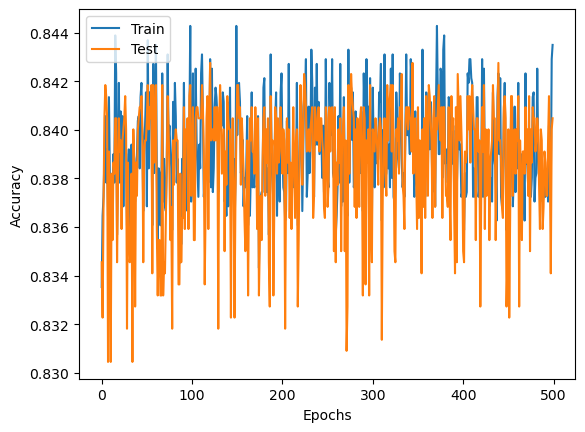

In [ ]:
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Test")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

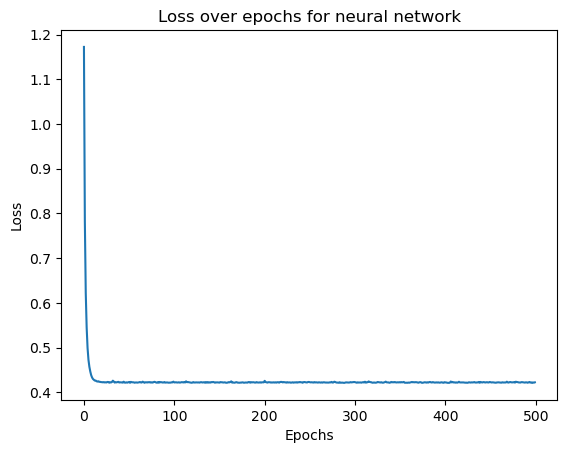

In [ ]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs for neural network')

# Display the plot
plt.show()

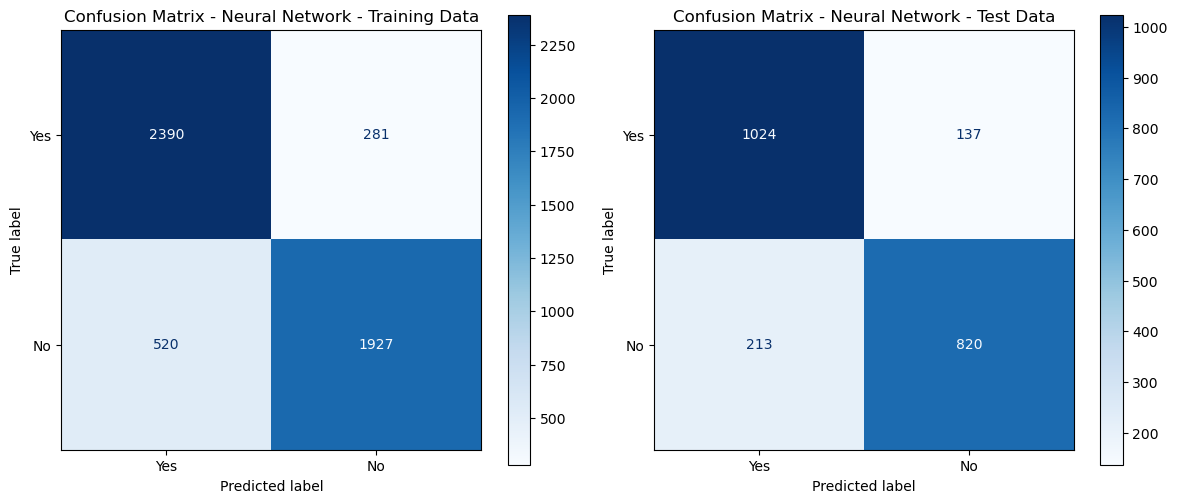

In [ ]:
# Convert true labels to numpy arrays
true_labels_train = Y_train_tensor.view(-1).numpy()
true_labels_test = Y_test_tensor.view(-1).numpy()

# Create subplots for individual confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax = axes[0]
confusion_matrix_display = ConfusionMatrixDisplay.from_predictions(true_labels_train, predictions_train, ax=ax, cmap=plt.cm.Blues, display_labels=["Yes", "No"])
ax.set_title(f'Confusion Matrix - Neural Network - Training Data')
ax = axes[1]
confusion_matrix_display = ConfusionMatrixDisplay.from_predictions(true_labels_test, predictions_test, ax=ax, cmap=plt.cm.Blues, display_labels=["Yes", "No"])
ax.set_title(f'Confusion Matrix - Neural Network - Test Data')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
print(f"Classification Report for Neural Network - Training Data:\n{classification_report(true_labels_train, predictions_train)}\n")
print(f"Classification Report for Neural Network - Test Data:\n{classification_report(true_labels_test, predictions_test)}")

Classification Report for Neural Network - Training Data:
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.86      2671
         1.0       0.87      0.79      0.83      2447

    accuracy                           0.84      5118
   macro avg       0.85      0.84      0.84      5118
weighted avg       0.85      0.84      0.84      5118


Classification Report for Neural Network - Test Data:
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85      1161
         1.0       0.86      0.79      0.82      1033

    accuracy                           0.84      2194
   macro avg       0.84      0.84      0.84      2194
weighted avg       0.84      0.84      0.84      2194


In [ ]:
conf_matrix, class_report, auc, acc = get_scores(true_labels_test, predictions_test)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')

## 5.4 ANN Model #3 (1 Layer with L2 Regularization)

### 5.4.1 Hyperparameter Tuning with Grid Search

In [ ]:
number_of_input_features = 14
epochs = 500

# Define the hyperparameter space
hyperparameter_space = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'number_of_hidden_units': [64, 128, 256],
    'landa': [0.001, 0.01, 0.1]
}

# Lists to store results for each set of hyperparameters
grid_search_results = []

# Grid Search
hyperparameter_combinations = list(itertools.product(*hyperparameter_space.values()))

for hyperparams_values in hyperparameter_combinations:
    # Create a dictionary with hyperparameters
    hyperparams = dict(zip(hyperparameter_space.keys(), hyperparams_values))

    # Create and train the model with the current set of hyperparameters
    model = nn.Sequential(
        nn.Linear(number_of_input_features, hyperparams['number_of_hidden_units']),
        nn.Tanh(),
        nn.Linear(hyperparams['number_of_hidden_units'], 1),
        nn.Sigmoid()
    )

    optimizer = Adam(model.parameters(), lr=hyperparams['learning_rate'])
    loss_fn = t.nn.BCELoss()

    # Prepare data loader
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_data_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)

    # Training loop
    for epoch in range(epochs):
        per_epoch_loss_list = []

        for batch_idx, (X, Y) in enumerate(train_data_loader):
            probs = model(X)
            l2_term = sum([(w ** 2).sum() for w in model.parameters()])
            loss = loss_fn(probs.view(-1), Y) + hyperparams['landa'] * l2_term
            per_epoch_loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate the model on validation data
    with t.no_grad():
        model.eval()

        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        grid_search_results.append({
            'hyperparameters': hyperparams,
            'validation_accuracy': validation_accuracy
        })



### 5.4.2 Selected Hyperparameters for ANN Model #3 (1 Layer with L2 Regularization)

In [ ]:
max_result = max(grid_search_results, key=lambda x: x['validation_accuracy'])
max_result

{'hyperparameters': {'learning_rate': 0.001,
  'batch_size': 64,
  'number_of_hidden_units': 128,
  'landa': 0.01},
 'validation_accuracy': 0.8422971963882446}

### 5.4.3 Run Tuned ANN Model #3 (1 Layer with L2 Regularization)

In [ ]:
number_of_input_features = 14
number_of_hidden_units = 128
epochs = 500
learning_rate = 0.001
batch_size = 64
landa = 0.01

# Prepare the data
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    nn.Tanh(),  # Tanh activation function
    nn.Linear(number_of_hidden_units, 1),  # Another linear layer
    nn.Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Binary Cross-Entropy Loss
loss_fn = t.nn.BCELoss()

train_accuracy_list = []  # List to store training accuracy
validation_accuracy_list = []  # List to store validation accuracy
train_loss_list = []  # List to store training loss
train_recall_list = [] # List to store training recall scores
validation_recall_list = [] # List to store validation recall scores
train_f1_list = [] # List to store training F1 scores
validation_f1_list = [] # List to store validation F1 scores

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []  # List to store losses for each epoch

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()
        predictions_train = (probs >= 0.5).type(t.LongTensor).view(-1).numpy()

        # Calculate precision, recall, and F1 score on train data
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(Y_train_tensor, prediction, average='binary')
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1)

        # Calculate accuracy on test data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()
        predictions_test = (probs >= 0.5).type(t.LongTensor).view(-1).numpy()

        # Calculate precision, recall, and F1 score on test data
        validation_precision, validation_recall, validation_f1, _ = precision_recall_fscore_support(Y_test_tensor, prediction, average='binary')
        validation_recall_list.append(validation_recall)
        validation_f1_list.append(validation_f1)

        # Print accuracy for the current epoch
 

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

### 5.4.4 Metrics of Tuned ANN Model #3 (2 Layers without Dropout)

In [89]:
last_validation_accuracy = validation_accuracy_list[-1]
last_validation_accuracy

0.8395624160766602

In [90]:
last_validation_recall = validation_recall_list[-1]
last_validation_recall

0.7996127783155856

In [91]:
last_validation_f1 = validation_f1_list[-1]
last_validation_f1

0.8243512974051896

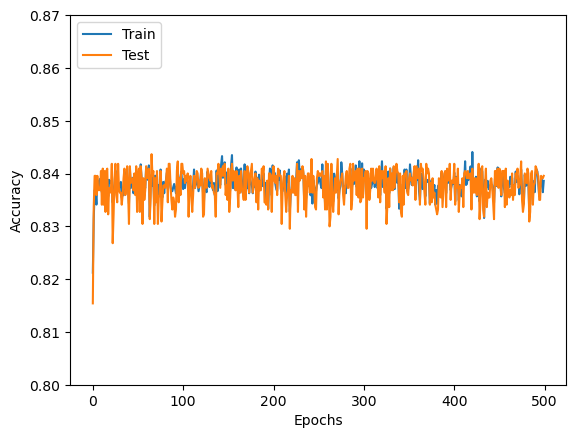

In [92]:
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Test")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.8,0.87)
plt.show()

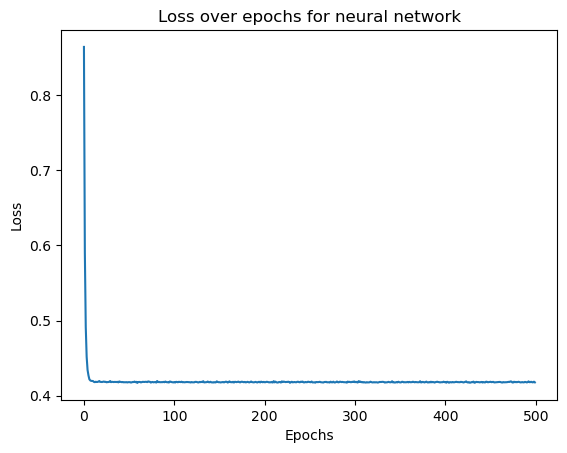

In [93]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs for neural network')

# Display the plot
plt.show()

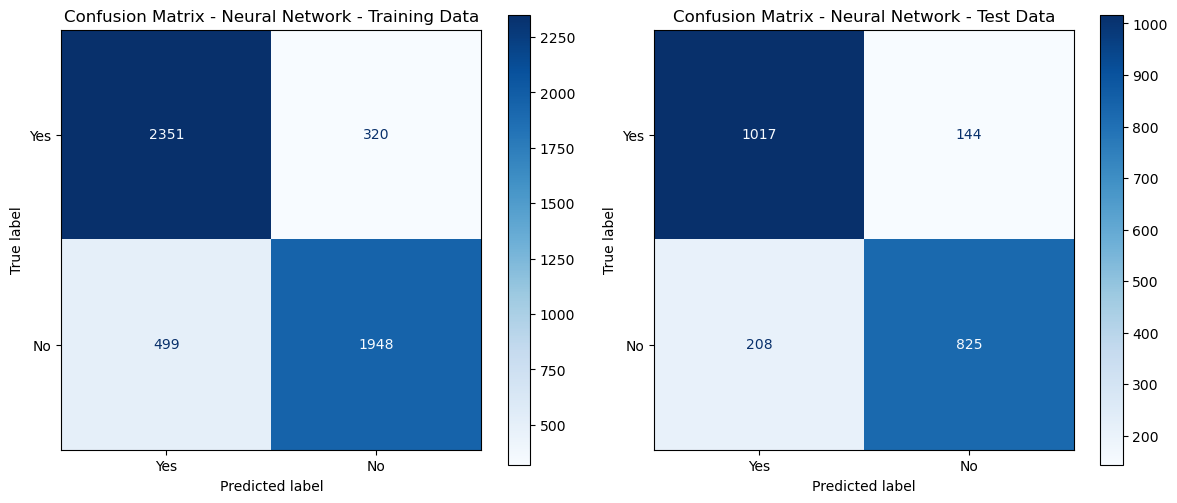

In [83]:
# Convert true labels to numpy arrays
true_labels_train = Y_train_tensor.view(-1).numpy()
true_labels_test = Y_test_tensor.view(-1).numpy()

# Create subplots for individual confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax = axes[0]
confusion_matrix_display = ConfusionMatrixDisplay.from_predictions(true_labels_train, predictions_train, ax=ax, cmap=plt.cm.Blues, display_labels=["Yes", "No"])
ax.set_title(f'Confusion Matrix - Neural Network - Training Data')
ax = axes[1]
confusion_matrix_display = ConfusionMatrixDisplay.from_predictions(true_labels_test, predictions_test, ax=ax, cmap=plt.cm.Blues, display_labels=["Yes", "No"])
ax.set_title(f'Confusion Matrix - Neural Network - Test Data')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [95]:
print(f"Classification Report for Neural Network - Training Data:\n{classification_report(true_labels_train, predictions_train)}\n")
print(f"Classification Report for Neural Network - Test Data:\n{classification_report(true_labels_test, predictions_test)}")

Classification Report for Neural Network - Training Data:
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      2671
         1.0       0.86      0.80      0.83      2447

    accuracy                           0.84      5118
   macro avg       0.84      0.84      0.84      5118
weighted avg       0.84      0.84      0.84      5118


Classification Report for Neural Network - Test Data:
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85      1161
         1.0       0.85      0.80      0.82      1033

    accuracy                           0.84      2194
   macro avg       0.84      0.84      0.84      2194
weighted avg       0.84      0.84      0.84      2194


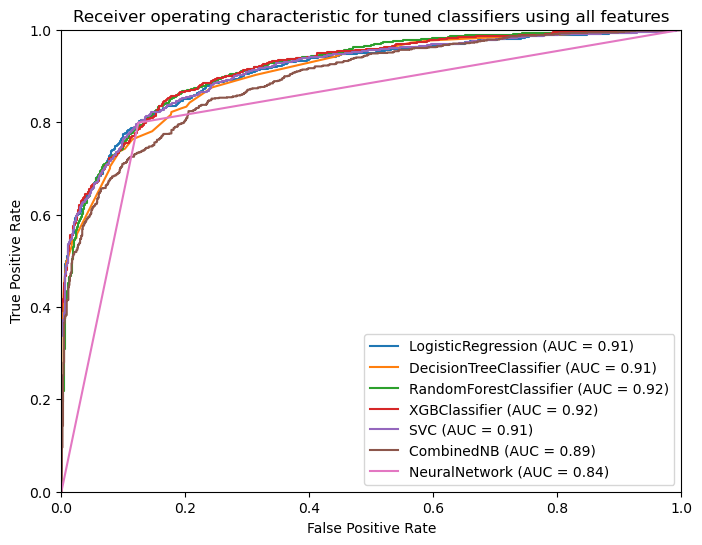

In [84]:
# ROC CURVE PLOT FOR ALL FEATURES AND CLASSIFIERS - USED IN MANUSCRIPT
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate over the tuned classifiers and plot ROC curve for each
for classifier_name, result in results.items():
    # Get the best estimator from the results
    best_estimator = result['classifier']

    # Plot ROC curve
    roc_curve_display = RocCurveDisplay.from_estimator(best_estimator, X_test, Y_test, name=classifier_name, ax=ax)

roc_curve_display = RocCurveDisplay.from_predictions(Y_test, y_hat_prob[:, 1], name='CombinedNB', ax=ax)
roc_curve_display = RocCurveDisplay.from_predictions(true_labels_test, predictions_test, name='NeuralNetwork', ax=ax)

# Add a legend
ax.legend()

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for tuned classifiers using all features')
plt.ylim(0.0,1)
plt.xlim(0.0,1)

# Display the plot
plt.show()

AUC :  0.837573677597091
Accuracy :  0.8395624430264357
Confusion Matrix:
[[1012  149]
 [ 203  830]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      1161
         1.0       0.85      0.80      0.83      1033

    accuracy                           0.84      2194
   macro avg       0.84      0.84      0.84      2194
weighted avg       0.84      0.84      0.84      2194


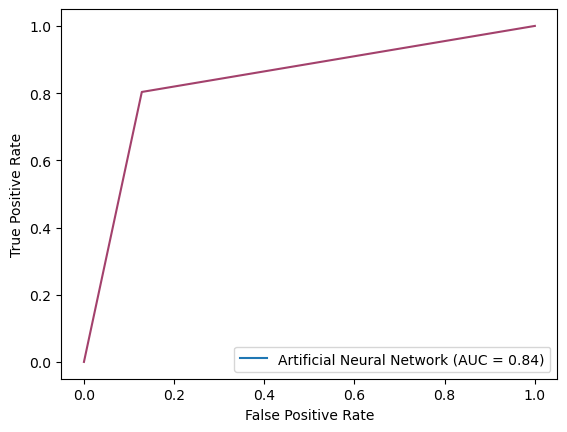

In [125]:
conf_matrix, class_report, auc, acc = get_scores(true_labels_test, predictions_test)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels_test, predictions_test)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Artificial Neural Network')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')

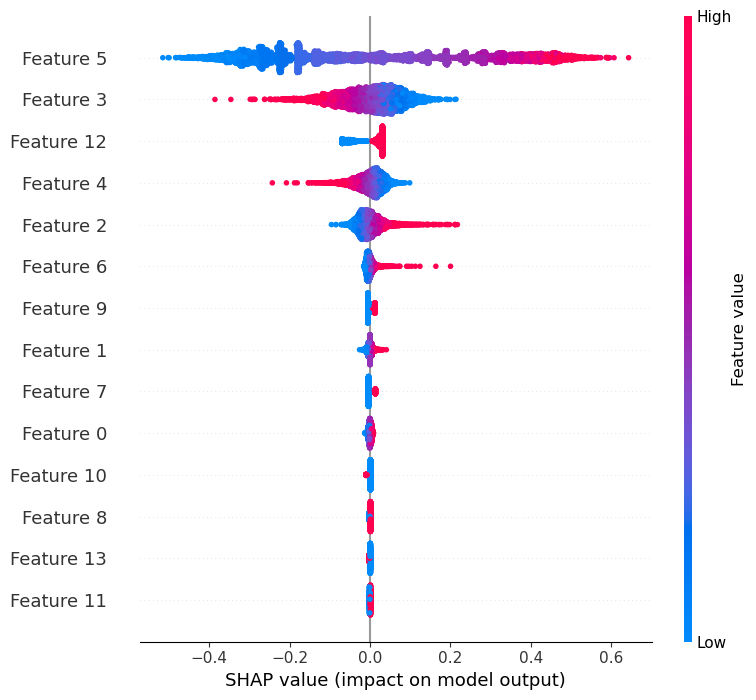

In [124]:
explainer = shap.DeepExplainer(model, X_train_tensor)
shap_values = explainer.shap_values(X_train_tensor)

# Summary dot plots
shap.summary_plot(shap_values, X_train_tensor, plot_type = "dot")

# 6 Model Validation

In [142]:
# Remove FBS due to collinearity with A1c and literature showing A1c is accurate and longer-term measure compared to FBS
# Remove Total_Cholesterol due to collinearity with LDL and HDL
# Remove dates due to uninformative
df_valid = df_valid.drop(columns=dropping_columns, axis=1)

# Extract the 'Diabetes' column as the target variable for training and testing
Y_valid = df_valid['Diabetes']

# Extract the features (excluding 'Diabetes') for training and testing
X_valid = df_valid.drop('Diabetes', axis=1)

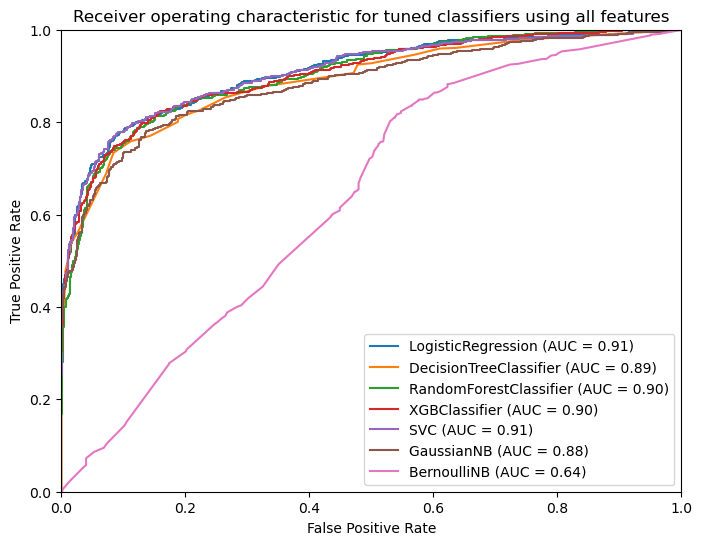

In [147]:
# ROC CURVE PLOT FOR ALL FEATURES AND CLASSIFIERS
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate over the tuned classifiers and plot ROC curve for each
for classifier_name, result in results.items():
    # Get the best estimator from the results
    best_estimator = result['classifier']

    # Plot ROC curve
    roc_curve_display = RocCurveDisplay.from_estimator(best_estimator, X_valid, Y_valid, name=classifier_name, ax=ax)

# Add a legend
ax.legend()

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for tuned classifiers using all features')
plt.ylim(0.0,1)
plt.xlim(0.0,1)

# Display the plot
plt.show()

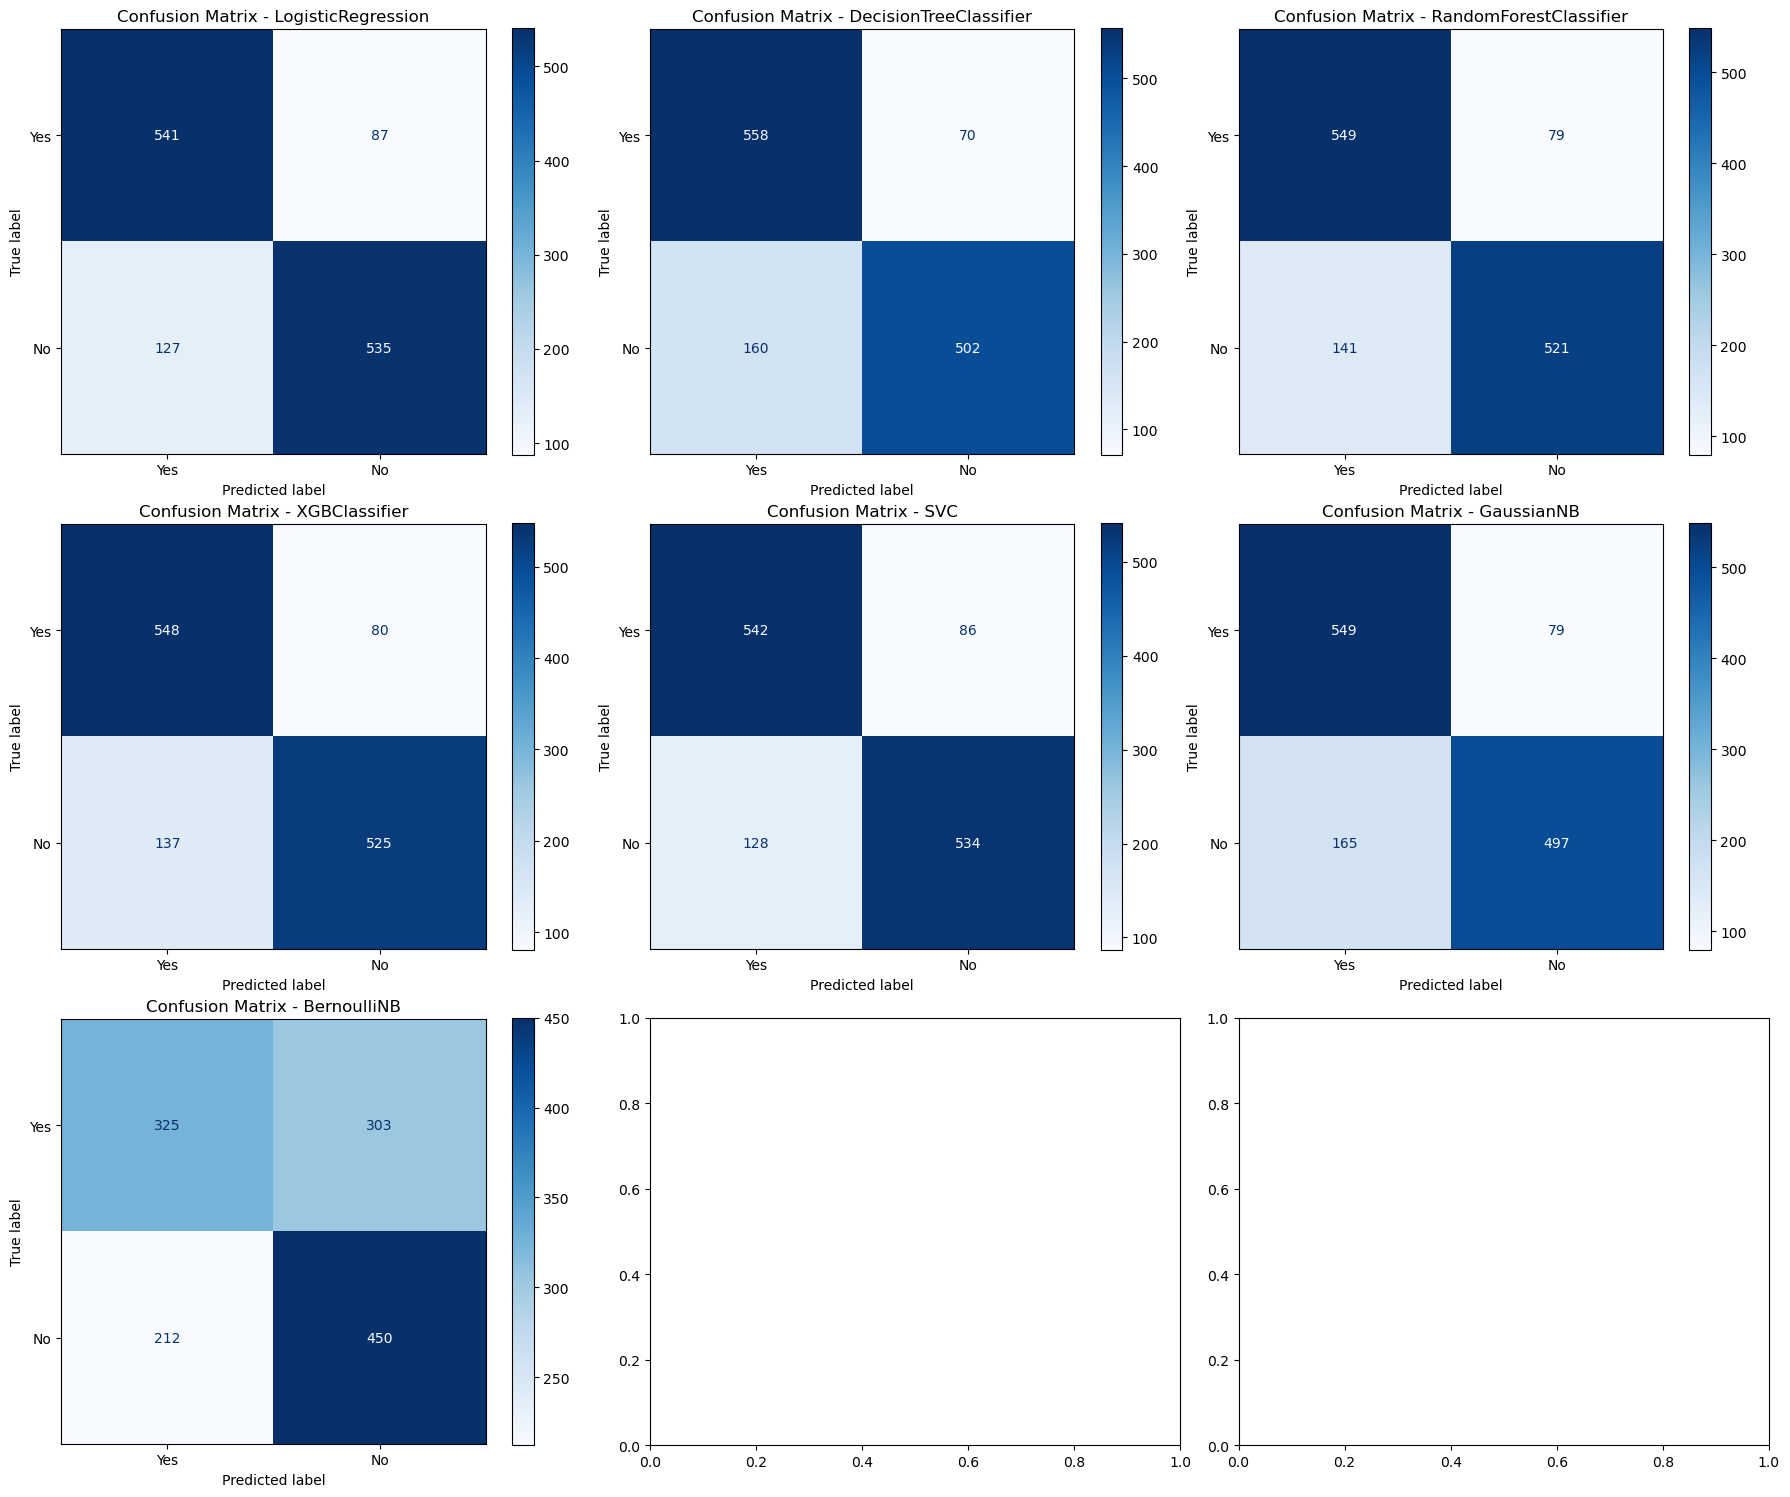

In [148]:
# CONFUSION MATRICES FOR ALL FEATURES AND CLASSIFIERS
# Create subplots for individual confusion matrices
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))

# Iterate over the tuned classifiers and plot confusion matrix for each
for i, (classifier_name, result) in enumerate(results.items()):
    # Get the best estimator from the results
    best_estimator = result['classifier']

    # Calculate predictions on the test set
    y_pred = best_estimator.predict(X_valid)

    # Plot confusion matrix
    ax = axes[i // 3, i % 3]
    confusion_matrix_display = ConfusionMatrixDisplay.from_estimator(best_estimator, X_valid, Y_valid, ax=ax, cmap=plt.cm.Blues, display_labels=["Yes", "No"])
    ax.set_title(f'Confusion Matrix - {classifier_name}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [149]:
# Print the classification report for each tuned classifier
for classifier_name, result in results.items():
    # Get the best estimator from the results
    best_estimator = result['classifier']

    # Calculate predictions on the test set
    Y_pred = best_estimator.predict(X_valid)

    # Print the classification report
    print(f"Classification Report for {classifier_name}:\n{classification_report(Y_valid, Y_pred)}\n")

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       628
           1       0.86      0.81      0.83       662

    accuracy                           0.83      1290
   macro avg       0.84      0.83      0.83      1290
weighted avg       0.84      0.83      0.83      1290


Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       628
           1       0.88      0.76      0.81       662

    accuracy                           0.82      1290
   macro avg       0.83      0.82      0.82      1290
weighted avg       0.83      0.82      0.82      1290


Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       628
           1       0.87      0.79      0.83       662

    accuracy                      